---

## **1. Import Libraries**

In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.io import show
import plotly.io as pio

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

print("Libraries imported successfully")

Libraries imported successfully


---
## **2. Load Data**

We'll load two CSV files directly from Kaggle using `kagglehub`:
1. **TeamStatistics.csv**: Detailed game-level statistics for each team
2. **Games.csv**: Game metadata including game type (Regular Season vs Playoffs)

**Data Source**: [Historical NBA Data and Player Box Scores](https://www.kaggle.com/datasets/eoinamoore/historical-nba-data-and-player-box-scores) by Eoin Moore

**Note**: First run will download the dataset (~100MB). Subsequent runs will use cached data.

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

stats_filepath = "TeamStatistics.csv"
games_filepath = "Games.csv"

team_stats = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "eoinamoore/historical-nba-data-and-player-box-scores",
    stats_filepath
  )
games = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "eoinamoore/historical-nba-data-and-player-box-scores",
    games_filepath
  )

print("Data loaded successfully from kaggle.")
print(f"Team Statistics Shape: {team_stats.shape}")
print(f"Games Shape: {games.shape}")

100%|██████████| 32.6M/32.6M [00:01<00:00, 29.6MB/s]


100%|██████████| 9.56M/9.56M [00:00<00:00, 14.0MB/s]


Data loaded successfully from kaggle.
Team Statistics Shape: (144622, 48)
Games Shape: (72311, 17)


---

## **2. Initial Data Exploration**

In [ ]:
# Display first few rows of team statistics
print("=== Team Statistics Sample ===\n")
print(team_stats.head())

# Check data info
print("\n=== Data Types and Missing Values ===\n")
print(team_stats.info())

# Check for missing values
print("\n=== Missing Values Summary ===\n")
missing = team_stats.isnull().sum()
missing_pct = (missing / len(team_stats)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Percentage': missing_pct})
print(missing_df[missing_df['Missing_Count'] > 0].sort_values(
    'Missing_Count', ascending=False))

=== Team Statistics Sample ===

     gameId      gameDateTimeEst       teamCity teamName      teamId  \
0  22501204  2025-12-10 17:00:00    Los Angeles   Lakers  1610612747   
1  22501204  2025-12-10 17:00:00    San Antonio    Spurs  1610612759   
2  22501203  2025-12-10 14:30:00        Phoenix     Suns  1610612756   
3  22501203  2025-12-10 14:30:00  Oklahoma City  Thunder  1610612760   
4  22501202  2025-12-09 15:30:00       New York   Knicks  1610612752   

  opponentTeamCity opponentTeamName  opponentTeamId  home  win  teamScore  \
0      San Antonio            Spurs      1610612759     1    0        119   
1      Los Angeles           Lakers      1610612747     0    1        132   
2    Oklahoma City          Thunder      1610612760     0    0         89   
3          Phoenix             Suns      1610612756     1    1        138   
4          Toronto          Raptors      1610612761     0    1        117   

   opponentScore  assists  blocks  steals  fieldGoalsAttempted  \
0     

---

## **3. Data Cleaning and Preparation**
Select only the needed columns from 'team_stats'.

In [ ]:
print("\nSelecting only necessary columns from team_stats...")

# Core columns
core_cols = [
    'gameId',           # Join key
    'gameDateTimeEst',  # Temporal analysis
    'teamCity',         # Team identification
    'teamName',         # Team identification
    'opponentTeamCity', # Opponent identification
    'opponentTeamName', # Opponent identification
]

# Game outcome columns
outcome_cols = [
    'win',              # Win/loss
    'teamScore',        # Points scored
    'opponentScore',    # Points allowed
]

# Offensive statistics (for TPI offense score)
offensive_cols = [
    'fieldGoalsAttempted',
    'fieldGoalsMade',
    'fieldGoalsPercentage',
    'threePointersAttempted',
    'threePointersMade',
    'threePointersPercentage',
    'freeThrowsAttempted',
    'freeThrowsMade',
    'freeThrowsPercentage',
    'assists',
    'turnovers'
]

# Defensive statistics (for TPI defense score)
defensive_cols = [
    'blocks',
    'steals',
    'reboundsDefensive',
    'reboundsOffensive',
]

# Intangibles statistics (for TPI intangibles score)
intangibles_cols = [
    'plusMinusPoints',
    'reboundsTotal'
]

# Combine all needed columns
needed_cols = (
    core_cols +
    outcome_cols +
    offensive_cols +
    defensive_cols +
    intangibles_cols
)

print(f"  - Total columns in team_stats: {len(team_stats.columns)}")
print(f"  - Columns we need: {len(needed_cols)}")
print(f"  - Columns we'll skip: {len(team_stats.columns) - len(needed_cols)}")

team_stats = team_stats[needed_cols].copy()

print(f"  - Minimal team_stats shape: {team_stats.shape}")
print(f"  - team_stats columns: {team_stats.columns}")


Selecting only necessary columns from team_stats...
  - Total columns in team_stats: 48
  - Columns we need: 26
  - Columns we'll skip: 22
  - Minimal team_stats shape: (144622, 26)
  - team_stats columns: Index(['gameId', 'gameDateTimeEst', 'teamCity', 'teamName', 'opponentTeamCity',
       'opponentTeamName', 'win', 'teamScore', 'opponentScore',
       'fieldGoalsAttempted', 'fieldGoalsMade', 'fieldGoalsPercentage',
       'threePointersAttempted', 'threePointersMade',
       'threePointersPercentage', 'freeThrowsAttempted', 'freeThrowsMade',
       'freeThrowsPercentage', 'assists', 'turnovers', 'blocks', 'steals',
       'reboundsDefensive', 'reboundsOffensive', 'plusMinusPoints',
       'reboundsTotal'],
      dtype='object')


In [ ]:
# Combine city + team for both team and opponent
team_stats['team'] = team_stats['teamCity'].astype(str) + ' ' + team_stats['teamName'].astype(str)
team_stats['opponent'] = team_stats['opponentTeamCity'].astype(str) + ' ' + team_stats['opponentTeamName'].astype(str)

# Drop the old separate columns
team_stats = team_stats.drop(columns=['teamCity', 'teamName', 'opponentTeamCity', 'opponentTeamName'])

# Sort by gameId
team_stats = team_stats.sort_values(by='gameId').reset_index(drop=True)

In [ ]:
# Select only needed columns from games
games = games.drop(columns=['gameDateTimeEst','hometeamCity', 'hometeamName', 'hometeamId',
                            'awayteamCity', 'awayteamName', 'awayteamId',
                            'homeScore', 'awayScore', 'winner', 'attendance',
                            'arenaId', 'gameLabel','gameSubLabel', 'seriesGameNumber'
])

### **3.1 Parse Date Column**

The `gameDateTimeEst` column is in ISO 8601 format (e.g., `2025-11-12T22:30:00Z`). We'll parse it to datetime for potential time-based analysis.

In [ ]:
# Remove the timestamps on gameDateTimeEst and just keep the date
team_stats['gameDate'] = pd.to_datetime(team_stats['gameDateTimeEst'], format='mixed', utc=True, errors='coerce').dt.date

# Drop rows where month or year are null
before = len(team_stats)
team_stats = team_stats.dropna(subset=['gameDateTimeEst'])
after = len(team_stats)

print("Date column parsed successfully.")
print(f"Dropped {before - after} rows with invalid or missing dates.\n")
print(f"Date range: {team_stats['gameDate'].min()} to {team_stats['gameDate'].max()}\n")
print("Sample dates:")
print(team_stats[['gameId', 'gameDate']].head(2))

Date column parsed successfully.
Dropped 0 rows with invalid or missing dates.

Date range: 1946-11-26 to 2025-12-10

Sample dates:
     gameId    gameDate
0  10300001  2003-10-05
1  10300001  2003-10-05


### **3.2 Create 'Season' Column**

In [ ]:
# Create season colummn
def get_season(date):
    year = date.year
    month = date.month

    # NBA season typically starts in October and ends in June
    if month >= 10:   # October, November, December -> season starts this year
        return f"{year}-{year + 1}"
    else:             # January to June -> season started previous year
        return f"{year - 1}-{year}"

team_stats['season'] = team_stats['gameDate'].apply(get_season)

### **3.3 Merge to obtain 'GameType'**

In [ ]:
team_stats = team_stats.merge(
    games[['gameId', 'gameType']],
    on='gameId',
    how='left'
)

In [ ]:
team_stats.to_csv("Full_GameLevel.csv", index=False)

### **3.4 Self-Join to Retrieve Opponent Statistics**

Our cleaned game-level dataset initially contains **one row per team per game**, meaning each NBA game appears twice—once from each team’s perspective. While the row provides complete box-score information for the *team*, it does **not** include the opponent’s detailed statistics. Instead, only the opponent’s final score is available.

However, calculating several core defensive metrics requires the opponent’s box-score values. Examples include:

* opponent field goal percentage
* opponent 3-point percentage
* defensive rebound percentage
* steal and block percentage
* opponent turnover percentage
* defensive rating

These metrics cannot be computed accurately without access to the opponent’s true stat line.

---

#### **The Problem**

Before the self-join, each row contains:

* the team’s full offensive and defensive stats
* the opponent’s *score only*
* **no opponent box-score data**

This means raw opponent variables such as:

* `fieldGoalsAttempted`
* `fieldGoalsPercentage`
* `reboundsOffensive`
* `reboundsDefensive`
* `turnovers`
* etc.

are missing from the row. Without these values, defensive analytics would require approximations or inferred stats, weakening the reliability of the final model.

---

#### **The Solution**

To attach true opponent-side statistics to each row, we perform a **self-join on `gameId`**, taking advantage of the fact that:

> Every game appears exactly twice—once for each participating team.

This allows us to merge the opponent’s row into the team’s row.

---

#### **How the Self-Join Is Performed**

1. **Sort** the dataset by `gameId` to ensure consistency.
2. **Assign labels** (e.g., A and B) within each game, since there are exactly two entries per game.
3. **Split the dataset** into two aligned tables:

   * `team_a`: the primary team perspective
   * `team_b`: the opponent’s perspective
4. **Select** only the columns from `team_b` that represent opponent box-score metrics.
5. **Rename** these opponent columns using an `_opp` suffix.
6. **Merge** them onto the corresponding row in `team_a` using `gameId`.
7. **Verify** that each resulting row contains:

   * team statistics
   * opponent statistics (properly aligned via `_opp`)
   * correct scores for both sides

---

#### **Illustrative Example**

**Before Self-Join (Two Rows Per Game):**

| gameId   | team     | FG%   | opponentScore |
| -------- | -------- | ----- | ------------- |
| 10300001 | Bulls    | 0.457 | 110           |
| 10300001 | Warriors | 0.488 | 102           |

**After Self-Join (One Row Per Team Per Game, With Opponent Stats):**

| gameId   | team     | FG% (team) | FG%_opp |
| -------- | -------- | ---------- | ------- |
| 10300001 | Bulls    | 0.457      | 0.488   |
| 10300001 | Warriors | 0.488      | 0.457   |

The resulting dataset now contains a complete statistical picture for both sides of the matchup.

---

#### **Why This Step Is Essential**

After the self-join, each row becomes a comprehensive representation of the game from the team’s point of view. This enables **accurate construction of defensive performance metrics**, including:

* **Defensive Rating**
  (points allowed per 100 possessions)
* **Opponent Effective Field Goal Percentage (eFG%_opp)**
* **Opponent True Shooting Percentage (TS%_opp)**
* **Opponent Turnover Percentage (TOV%_opp)**
* **Defensive Rebound Percentage (DREB%)**
* **Block and Steal Rates**

These metrics require the opponent’s true box-score values. Without a self-join, they cannot be computed correctly.


In [ ]:
# Start from the original team_stats dataset
df = team_stats.copy()

# Sort for deterministic A/B pairing
df = df.sort_values(["gameId", "team"]).reset_index(drop=True)

# Create row index per game
df["row_in_game"] = df.groupby("gameId").cumcount()

# Split into team A (row 0) and team B (row 1)
A = df[df["row_in_game"] == 0].copy()
B = df[df["row_in_game"] == 1].copy()

print("A/B split complete:", len(A), len(B))

A/B split complete: 72311 72311


In [ ]:
opponent_stats_needed = [
    'fieldGoalsAttempted', 'fieldGoalsMade', 'fieldGoalsPercentage',
    'threePointersAttempted', 'threePointersMade', 'threePointersPercentage',
    'freeThrowsAttempted', 'freeThrowsMade', 'freeThrowsPercentage',
    'assists', 'turnovers', 'blocks', 'steals',
    'reboundsDefensive', 'reboundsOffensive', 'reboundsTotal'
]

# Map team-side stats -> opponent stat names
rename_map = {col: col + "_opp" for col in opponent_stats_needed}

# Also rename identity + scoring columns in B
rename_map.update({
    "team": "opponent",
    "teamScore": "opponentScore"
})

# Columns needed from B before renaming
cols_to_keep_from_B = ["gameId"] + list(rename_map.keys())

# Extract and rename from B
B_trimmed = B[cols_to_keep_from_B].copy()
B_renamed = B_trimmed.rename(columns=rename_map)

# Drop duplicates that will conflict after merge
B_renamed = B_renamed.drop(columns=['opponent', 'opponentScore'])

print("B_renamed columns:", B_renamed.columns.tolist())

B_renamed columns: ['gameId', 'fieldGoalsAttempted_opp', 'fieldGoalsMade_opp', 'fieldGoalsPercentage_opp', 'threePointersAttempted_opp', 'threePointersMade_opp', 'threePointersPercentage_opp', 'freeThrowsAttempted_opp', 'freeThrowsMade_opp', 'freeThrowsPercentage_opp', 'assists_opp', 'turnovers_opp', 'blocks_opp', 'steals_opp', 'reboundsDefensive_opp', 'reboundsOffensive_opp', 'reboundsTotal_opp']


In [ ]:
merged = A.merge(B_renamed, on="gameId", how="inner")
merged = merged.drop(columns=["row_in_game"])
print("Merged shape:", merged.shape)

Merged shape: (72311, 43)


### **3.5 Filter for Regular Season + Playoff Games Only**

In [ ]:
valid_types = ["Regular Season", "Playoffs"]
merged_fixed = merged[merged["gameType"].isin(valid_types)]

In [ ]:
# Reorder columns for readability
front_cols = ["gameId", "gameDate", "team", "opponent", "season", "gameType"]
other_cols = [c for c in merged_fixed.columns if c not in front_cols + ["ab_flag"]]

merged_fixed = merged_fixed[front_cols + other_cols]

In [ ]:
# Remove the mislabeled NBA Cup game
final = merged_fixed[merged_fixed["gameId"] != 62400001].copy()

# Confirm it is gone
print("Remaining entries for gameId 62400001:",
      final[final["gameId"] == 62400001].shape[0])

Remaining entries for gameId 62400001: 0


In [ ]:
# Identify rows where both scores are zero AND key stats are all NaN
key_stat_cols = [
    'fieldGoalsAttempted', 'fieldGoalsMade', 'fieldGoalsPercentage',
    'threePointersAttempted', 'threePointersMade', 'threePointersPercentage',
    'freeThrowsAttempted', 'freeThrowsMade', 'freeThrowsPercentage',
    'assists', 'turnovers', 'blocks', 'steals',
    'reboundsDefensive', 'reboundsOffensive', 'reboundsTotal'
]

# Rows where ALL key stats are NaN
null_stats_mask = final[key_stat_cols].isna().all(axis=1)

# Rows where both teams have zero points (impossible for a completed NBA game)
zero_score_mask = (final['teamScore'] == 0) & (final['opponentScore'] == 0)

# Identify invalid rows
invalid_rows = final[null_stats_mask & zero_score_mask]

print("Invalid rows to remove:")
print(invalid_rows[['gameId', 'team', 'opponent', 'season', 'gameDate', 'gameType']])

# Drop invalid rows
final_cleaned = final[~(null_stats_mask & zero_score_mask)].copy()

print("\nRows removed:", len(invalid_rows))
print("Final cleaned shape:", final_cleaned.shape)

Invalid rows to remove:
         gameId           team            opponent     season    gameDate  \
31288  22400627      Utah Jazz  Washington Wizards  2024-2025  2025-03-19   
31649  22400988  Orlando Magic   San Antonio Spurs  2024-2025  2025-04-01   

             gameType  
31288  Regular Season  
31649  Regular Season  

Rows removed: 2
Final cleaned shape: (69976, 43)


In [ ]:
final_cleaned.to_csv("Merged_Full_GameLevel.csv", index=False)

## **4. Filter to targeted teams**
### **Force Team Perspective**

After performing the self-join, each row contains a complete statistical profile of a single game: the team’s box score, the opponent’s box score, both final scores, and game context. However, for the three teams we analyze in this project—

* **1995–1996 Chicago Bulls**,

* **2015–2016 Golden State Warriors**, and

* **2024–2025 Oklahoma City Thunder**—
  the dataset includes games where these teams appear in both positions:

* sometimes in the **team** column

* sometimes in the **opponent** column

This creates a problem: all downstream modeling and feature engineering require the data to be **oriented consistently from the target team’s perspective**. Metrics such as:

* win/loss indicator
* scoring margin (plus-minus)
* team and opponent box-score features
* derived offensive/defensive metrics

must all reflect **the same viewpoint**: the target team as the “team” for every row.

---

#### **The Problem**

Without correction, the dataset contains rows like:

| gameId   | team                  | opponent              | teamScore | opponentScore |
| -------- | --------------------- | --------------------- | --------- | ------------- |
| 21500045 | Houston Rockets       | Golden State Warriors | 110       | 102           |
| 21500046 | Golden State Warriors | San Antonio Spurs     | 121       | 110           |

From the Warriors’ point of view:

* The second row is correctly aligned (Warriors = team)
* The first row is inverted (Warriors = opponent)

This inconsistency makes the following metrics misleading:

* `win` (which is based on *teamScore*, not the Warriors’ score)
* `plusMinusPoints` (scoring margin)
* team-side shooting and rebounding stats
* all `_opp` defensive indicators

To perform valid modeling, **every game must be reframed so the target team appears on the team side**.

---

#### **The Solution: Force Team Perspective**

We correct this by systematically identifying all rows where the target team appears as the **opponent**, and then **swapping** all directional values so the row is rewritten from the target team’s point of view.

##### **Rows that require swapping**

A row triggers a swap if:

```
opponent == target_team
```

##### **What must be swapped?**

**1. Identity Columns**
These define the orientation of the row:

* `team` ↔ `opponent`
* `teamScore` ↔ `opponentScore`

**2. Paired Box-Score Columns**
Every stat that exists in a team/opp pair must be reversed:

* field goal attempts, makes, percentages
* three-point attempts, makes, percentages
* free throws, makes, percentages
* assists, turnovers, steals, blocks
* offensive & defensive rebounds
* total rebounds

For each pair:

```
stat ↔ stat_opp
```

This ensures all team-side columns refer to the target team, and all `_opp` columns refer to the opponent.

**3. Recomputed Values**
Two columns must be recalculated after swapping:

* `win`
* `plusMinusPoints`

These depend directly on the corrected scores and must reflect the true outcome for the target team.

---

#### **Why This Step Is Essential**

Once applied, this transformation guarantees:

* The target team always appears as the “team”
* All directional metrics are correctly oriented
* Wins, losses, and scoring margins are correct
* Derived statistics (offensive/defensive ratings, possession-based metrics, etc.) become meaningful and coherent
* No data leakage or orientation bias enters the modeling pipeline

Without this step, statistical features for the target team would be inconsistently defined across rows, leading to misleading model behavior and incorrect interpretations.

---

#### **Example Before and After Perspective Correction**

**Before (Warriors appear as opponent):**

| team            | opponent              | teamScore | opponentScore | fieldGoalsAttempted | fieldGoalsAttempted_opp |
| --------------- | --------------------- | --------- | ------------- | ------------------- | ----------------------- |
| Houston Rockets | Golden State Warriors | 110       | 102           | 85                  | 91                      |

**After Forcing Warriors’ Perspective:**

| team                  | opponent        | teamScore | opponentScore | fieldGoalsAttempted | fieldGoalsAttempted_opp |
| --------------------- | --------------- | --------- | ------------- | ------------------- | ----------------------- |
| Golden State Warriors | Houston Rockets | 102       | 110           | 91                  | 85                      |

All directional fields now express the game from Golden State’s viewpoint.


### **4.1 Identify Directional Columns**

In [ ]:
df = final_cleaned.copy()

# Identity columns (always swapped)
identity_swap_cols = ['team', 'opponent', 'teamScore', 'opponentScore']

# Paired stats that MUST be swapped (team ↔ team_opp)
paired_swap_cols = []
for col in df.columns:
    if col.endswith('_opp'):
        team_col = col.replace('_opp', '')
        if team_col in df.columns:
            paired_swap_cols.append((team_col, col))

print("\nPaired columns identified for swapping:")
for t, o in paired_swap_cols:
    print(f"{t} ↔ {o}")

# Columns that must be recomputed after swap
recompute_cols = ['win', 'plusMinusPoints']

# Everything else stays as-is
all_swap_cols = identity_swap_cols + [t for t, o in paired_swap_cols] + [o for t, o in paired_swap_cols] + recompute_cols
static_cols = [c for c in df.columns if c not in all_swap_cols]

print("\nIdentity columns to swap:")
print(identity_swap_cols)

print("\nColumns to recompute:")
print(recompute_cols)

print("\nStatic columns (never swapped):")
print(static_cols)


Paired columns identified for swapping:
fieldGoalsAttempted ↔ fieldGoalsAttempted_opp
fieldGoalsMade ↔ fieldGoalsMade_opp
fieldGoalsPercentage ↔ fieldGoalsPercentage_opp
threePointersAttempted ↔ threePointersAttempted_opp
threePointersMade ↔ threePointersMade_opp
threePointersPercentage ↔ threePointersPercentage_opp
freeThrowsAttempted ↔ freeThrowsAttempted_opp
freeThrowsMade ↔ freeThrowsMade_opp
freeThrowsPercentage ↔ freeThrowsPercentage_opp
assists ↔ assists_opp
turnovers ↔ turnovers_opp
blocks ↔ blocks_opp
steals ↔ steals_opp
reboundsDefensive ↔ reboundsDefensive_opp
reboundsOffensive ↔ reboundsOffensive_opp
reboundsTotal ↔ reboundsTotal_opp

Identity columns to swap:
['team', 'opponent', 'teamScore', 'opponentScore']

Columns to recompute:
['win', 'plusMinusPoints']

Static columns (never swapped):
['gameId', 'gameDate', 'season', 'gameType', 'gameDateTimeEst']


### **4.2 Define 'force_team_perspective' Function**

In [ ]:
def force_team_perspective(df, target_team):
    """
    Forces all rows in df to be from the perspective of `target_team`.
    Suitable for one-row-per-game dataframes where each row already
    contains team and opponent stats.
    """

    df = df.copy()

    # Identify rows needing a swap
    # Rows where the target team is listed as the opponent
    mask_swap = df['opponent'] == target_team

    # Identify swap categories automatically

    # Identity swaps
    str_identity_cols = ['team', 'opponent']
    num_identity_cols = ['teamScore', 'opponentScore']

    # Paired team ↔ opponent stats
    paired_swap_cols = []
    for col in df.columns:
        if col.endswith("_opp"):
            team_col = col[:-4]  # strip "_opp"
            if team_col in df.columns:
                paired_swap_cols.append((team_col, col))

    # Columns to recompute
    recompute_cols = ['win', 'plusMinusPoints']

    # Apply swaps where mask_swap == True

    # Swap string identity columns
    df.loc[mask_swap, str_identity_cols] = \
        df.loc[mask_swap, str_identity_cols[::-1]].values

    # Swap numeric identity columns
    df.loc[mask_swap, num_identity_cols] = \
        df.loc[mask_swap, num_identity_cols[::-1]].values

    # Swap all paired stat columns
    for team_col, opp_col in paired_swap_cols:
        df.loc[mask_swap, [team_col, opp_col]] = \
            df.loc[mask_swap, [opp_col, team_col]].values

    # Recompute dependent values
    df['win'] = (df['teamScore'] > df['opponentScore']).astype(int)
    df['plusMinusPoints'] = df['teamScore'] - df['opponentScore']

    return df

### **4.3 Wrapper to Apply Perspective Correction by Season/Team**

In [ ]:
def apply_perspective_corrections(final_cleaned, target_teams):
    """
    Applies force_team_perspective() to each (season, team) pair defined
    in target_teams, and returns a corrected merged dataframe.

    final_cleaned : the full one-row-per-game dataframe after self-join + cleanup
    target_teams  : dict mapping season -> target team name
    """

    # Copy dataframe
    df = final_cleaned.copy()

    corrected_subsets = []

    for season, team in target_teams.items():

        # Extract rows belonging to that season AND involving the target team
        df_sub = df[
            (df['season'] == season) &
            ((df['team'] == team) | (df['opponent'] == team))
        ].copy()

        # Apply perspective correction
        df_corrected = force_team_perspective(df_sub, team)

        # Store corrected subset
        corrected_subsets.append(df_corrected)

    # Remove uncorrected original rows for these seasons
    df_remaining = df[~df['season'].isin(target_teams.keys())].copy()

    # Combine corrected and remaining rows
    final_corrected = pd.concat([df_remaining] + corrected_subsets, ignore_index=True)

    return final_corrected

### **4.4 Apply to Target Teams**

In [ ]:
target_teams = {
    '1995-1996': 'Chicago Bulls',
    '2015-2016': 'Golden State Warriors',
    '2024-2025': 'Oklahoma City Thunder'
}

In [ ]:
master_corrected = apply_perspective_corrections(final_cleaned, target_teams)

In [ ]:
# Sanity Check
for season, team in target_teams.items():
    count = sum(
        (master_corrected['season'] == season) &
        (master_corrected['team'] == team)
    )
    print(season, team, "— games:", count)


1995-1996 Chicago Bulls — games: 100
2015-2016 Golden State Warriors — games: 106
2024-2025 Oklahoma City Thunder — games: 105


In [ ]:
# Sanity Check
records = (
    master_corrected[
        master_corrected.apply(lambda x: target_teams.get(x['season']) == x['team'], axis=1)
    ]
    .groupby(['season','team','gameType'])
    .agg(
        games=('gameId','count'),
        wins=('win','sum')
    )
)
records['losses'] = records['games'] - records['wins']
print(records)

                                                games  wins  losses
season    team                  gameType                           
1995-1996 Chicago Bulls         Playoffs           18    15       3
                                Regular Season     82    72      10
2015-2016 Golden State Warriors Playoffs           24    15       9
                                Regular Season     82    73       9
2024-2025 Oklahoma City Thunder Playoffs           23    16       7
                                Regular Season     82    68      14


In [ ]:
master_corrected.to_csv("Final_Full_GameLevel.csv", index=False)

---

## **5. Feature Engineering**
### **5.1 Calculate Possessions**
Possessions are the foundation for pace-adjusted metrics.

**Formula**: ```Possessions = FGA - ORB + TOV + 0.4 × FTA```

Where:
- FGA = Field Goals Attempted
- ORB = Offensive Rebounds
- TOV = Turnovers
- FTA = Free Throws Attempted

In [ ]:
df = master_corrected.copy()

df['possessions'] = (
    df['fieldGoalsAttempted']
    - df['reboundsOffensive']
    + df['turnovers']
    + 0.4 * df['freeThrowsAttempted']
)

df['opp_possessions'] = (
    df['fieldGoalsAttempted_opp']
    - df['reboundsOffensive_opp']
    + df['turnovers_opp']
    + 0.4 * df['freeThrowsAttempted_opp']
)

### **5.2 Calculate Pace Factor**
The pace factor adjusts for different eras' playing speeds by comparing each team's possessions to the league average for that season.

**Formula**:```Pace Factor = Team Possessions / League Average Possessions```

This ensures teams from faster-paced eras (like 2010s-2020s) aren't unfairly advantaged.

In [ ]:
season_avg_poss = df.groupby('season')['possessions'].mean()

df['pace_factor'] = df.apply(
    lambda row: row['possessions'] / season_avg_poss[row['season']],
    axis=1
)

### **5.3 Calculate Offensive Metrics**

We calculate ten offensive metrics that collectively describe a team’s scoring efficiency, shooting profile, playmaking, ball security, and second-chance creation. All ten metrics are incorporated into the Total Performance Index (TPI) to produce a multi-dimensional view of offensive strength.

---

#### **Core Efficiency Metrics**

1. **Offensive Rating (ORtg)**
   Points scored per 100 possessions.
   This metric is inherently pace-adjusted and is one of the most important indicators of offensive performance.

2. **True Shooting Percentage (TS%)**
   Comprehensive shooting efficiency that accounts for the value of three-point shots and the bonus efficiency from free throws.

3. **Effective Field Goal Percentage (eFG%)**
   Field goal percentage adjusted for the added value of made three-point shots.

4. **Field Goal Percentage (FG%)**
   Basic shooting efficiency measuring made field goals relative to attempts.

---

#### **Volume and Style Metrics**

5. **True Shooting Attempts (TSA)**
   Represents total shooting volume, incorporating both field goal attempts and free throw attempts (scaled by 0.44).

6. **Free Throw Rate (FT Rate)**
   Frequency of free throw attempts relative to field goal attempts, capturing aggression and rim pressure.

7. **Three-Point Rate (3PT Rate)**
   Share of field goal attempts that come from beyond the arc, reflecting offensive shot selection and spacing.

---

#### **Playmaking and Ball Security**

8. **Assist Ratio**
   Assists per made field goal, indicating ball movement and play creation efficiency.

9. **Assist-to-Turnover Ratio (AST/TOV)**
   Balances playmaking and ball security by measuring assists relative to turnovers.

---

#### **Second-Chance and Transition**

10. **Offensive Rebound Percentage (ORB%)**
    Percentage of available offensive rebounds secured, capturing second-chance creation and transition pressure potential.

---

These ten metrics collectively quantify offensive identity and execution across efficiency, volume, shooting profile, ball movement, turnover avoidance, and second-chance opportunities. Together, they offer a complete, era-independent assessment of offensive performance.

---


In [ ]:
# Field Goal Percentage (pace-invariant)
df['FG_pct'] = np.where(
    df['fieldGoalsAttempted'] == 0,
    np.nan,
     (df['fieldGoalsMade'] / df['fieldGoalsAttempted']) * 100
)

# Assist-to-Turnover Ratio
df['AST_TOV'] = np.where(df['turnovers'] == 0, np.nan, df['assists'] / df['turnovers'])

# Offensive Rating (already pace-adjusted)
df['offRtg'] = (df['teamScore'] / df['possessions']) * 100

# True Shooting Percentage (pace-invariant)
ts_attempts = 2 * (df['fieldGoalsAttempted'] + 0.44 * df['freeThrowsAttempted'])
df['TS_pct'] = np.where(ts_attempts > 0, df['teamScore'] / ts_attempts, 0)

# Offensive Rebound Percentage
df['orb_pct'] = np.where(
    (df['reboundsOffensive'] + df['reboundsDefensive_opp']) == 0,
    np.nan,
    df['reboundsOffensive'] / (df['reboundsOffensive'] + df['reboundsDefensive_opp'])
)

# Effective Field Goal Percentage (pace-invariant)
df['eFG_pct'] = np.where(
    df['fieldGoalsAttempted'] == 0,
    np.nan,
     (df['fieldGoalsMade'] + 0.5 * df['threePointersMade']) / df['fieldGoalsAttempted']
)

# Assist Per Made Field Goal
df['ast_ratio'] = np.where(
    df['fieldGoalsMade'] == 0,
    np.nan,
    df['assists'] / df['fieldGoalsMade']
)

# True Shooting Attempts
df['tsa'] = df['fieldGoalsAttempted'] + 0.44 * df['freeThrowsAttempted']

# Free Throw Rate
df['ftr'] = np.where(
    df['fieldGoalsAttempted'] == 0,
    np.nan,
    df['freeThrowsAttempted'] / df['fieldGoalsAttempted']
)

# Three Point Rate
df['three_rate'] = np.where(
    df['fieldGoalsAttempted'] == 0,
    np.nan,
    df['threePointersAttempted'] / df['fieldGoalsAttempted']
)

print("Offensive metrics calculated")

Offensive metrics calculated


### **5.4 Calculate Defensive Metrics**

We compute eight core defensive metrics that collectively describe a team’s ability to prevent scoring, contest shots, control the glass, and generate turnovers. These metrics reflect the full defensive profile emphasized in modern basketball analytics.

---

#### **Scoring Prevention**

1. **Defensive Rating (DRtg)**
   Measures the number of points allowed per 100 opponent possessions.
   This is a pace-adjusted metric and a central indicator of defensive efficiency.
   *Lower values indicate stronger defense.*

2. **Points Allowed Per Game (PPG Allowed)**
   A raw measure of how many points the defense concedes per game.
   *Lower values indicate stronger defense.*

---

#### **Shooting Defense**

3. **Opponent Field Goal Percentage (Opp FG%)**
   The field goal percentage allowed to the opponent.
   Captures how well the defense contests and disrupts shot attempts.
   *Lower values are better.*

4. **Opponent Three-Point Percentage (Opp 3PT%)**
   The percentage of opponent three-point shots that were made.
   Indicates perimeter containment and close-out effectiveness.
   *Lower values are better.*

---

#### **Rebounding**

5. **Defensive Rebound Percentage (DREB%)**
   Measures the share of available defensive rebounds secured.
   Stronger defensive rebounding reduces opponent second-chance points.

---

#### **Disruption and Pressure**

6. **Steal Percentage (STL%)**
   Steals per opponent possession.
   Evaluates ball pressure and the ability to disrupt offensive flow.

7. **Block Percentage (BLK%)**
   Blocks per opponent two-point field goal attempt.
   Reflects rim protection and ability to contest shots inside the arc.

8. **Opponent Turnover Percentage (Opp TOV%)**
   Forced turnovers per opponent possession.
   Shows how often the defense creates pressure leading to mistakes.

---

These eight metrics provide a complete and balanced view of defensive performance:

* limiting scoring (DRtg, PPG Allowed)
* suppressing opponent efficiency (Opp FG%, Opp 3PT%)
* controlling the defensive glass (DREB%)
* generating disruption (STL%, BLK%, Opp TOV%)

Together, they allow for detailed evaluation of defensive strengths and weaknesses across eras and opponents.

---


In [ ]:
# Defensive Rating (opponent's ORtg)
df['defRtg'] = np.where(
    df['opp_possessions'] == 0,
    np.nan,
    (df['opponentScore'] / df['opp_possessions']) * 100
)

# Points Allowed Per Game
df['ppg_against'] = df['opponentScore']

# Defensive Rebound Percentage
df['dreb_pct'] = np.where(
    (df['reboundsDefensive'] + df['reboundsOffensive_opp']) == 0,
    np.nan,
    df['reboundsDefensive'] / (df['reboundsDefensive'] + df['reboundsOffensive_opp'])
)

# Opponent Field Goal Percentage
df['opp_fg_pct'] = df['fieldGoalsPercentage_opp']

# Opponent Three-Point Percentage
df['opp_three_pct'] = df['threePointersPercentage_opp']

# Steal Percentage
df['stl_pct'] = np.where(
    df['opp_possessions'] == 0,
    np.nan,
    df['steals'] / df['opp_possessions']
)

# Block Percentage (blocks per opponent 2PA)
opp_2pa = df['fieldGoalsAttempted_opp'] - df['threePointersAttempted_opp']

df['blk_pct'] = np.where(
    opp_2pa == 0,
    np.nan,
    df['blocks'] / opp_2pa
)

# Opponent Turnover Percentage
df['opp_tov_pct'] = np.where(
    df['opp_possessions'] == 0,
    np.nan,
    df['turnovers_opp'] / df['opp_possessions']
)

print("Defensive metrics calculated safely")

Defensive metrics calculated safely


### **5.5 Calculate Intangible Metrics**

We calculate 3 intangible metrics that capture team discipline, depth, and overall dominance:

#### **Ball Security & Discipline:**
1. **Turnover % (TOV%)**: Turnovers per possession (lower is better)

#### **Point Differential & Dominance:**

2. **Plus/Minus Per Game (+/-)**: Point differential for each game
3. **Net Rating**: Offensive rating minus defensive rating, measuring overall efficiency (pace-adjusted)

These 3 metrics capture how well teams protect the ball, dominate opponents, utilize depth, and maintain overall efficiency. Net Rating serves as the ultimate measure of team dominance by combining offensive and defensive performance into a single efficiency metric.

In [ ]:
# Net Rating
df['netRtg'] = df['offRtg'] - df['defRtg']

# Turnover Percentage (lower is better)
df['tov_pct'] = np.where(
    (df['fieldGoalsAttempted'] + 0.44 * df['freeThrowsAttempted'] + df['turnovers']) == 0,
    np.nan,
    df['turnovers'] / (
        df['fieldGoalsAttempted']
        + 0.44 * df['freeThrowsAttempted']
        + df['turnovers']
    )
)

# Plus/Minus per game (already in dataset)
df['pm_per_game'] = df['plusMinusPoints']

print("Intangible metrics calculated")

Intangible metrics calculated


---

## **6. Z-Score Normalization by Season**
To compare teams across different eras fairly, we normalize all metrics within each season using z-scores.

**Formula**:```Z-Score = (X - μ) / σ```

Where:
- X = Individual team's metric value
- μ = League average for that season
- σ = Standard deviation for that season

This transforms all metrics to a common scale where:
- **Z = 0**: League average performance
- **Z > 0**: Above average (positive standard deviations)
- **Z < 0**: Below average (negative standard deviations)

In [ ]:
# Define the metric groups
offensive_metrics = [
    'offRtg', 'TS_pct', 'eFG_pct', 'ast_ratio', 'tsa',
    'ftr', 'three_rate', 'FG_pct', 'AST_TOV', 'orb_pct'
]

defensive_metrics = [
    'defRtg', 'ppg_against', 'dreb_pct', 'opp_fg_pct',
    'opp_three_pct', 'stl_pct', 'blk_pct', 'opp_tov_pct'
]

intangible_metrics = [
    'tov_pct', 'pm_per_game', 'netRtg'
]

all_metrics = offensive_metrics + defensive_metrics + intangible_metrics

league_means = df[all_metrics].mean()
league_stds = df[all_metrics].std()

df_z = df.copy()

for m in all_metrics:
    df_z[m+"_Z"] = (df_z[m] - league_means[m]) / league_stds[m]

# Invert “lower is better” metrics
invert = ['defRtg_Z','ppg_against_Z','opp_fg_pct_Z','opp_three_pct_Z',
          'tov_pct_Z']

for m in invert:
    df_z[m] = -df_z[m]

---

## **7. Calculate Category Scores**
Each category score is the mean of its normalized metrics:
- **Offense Score**: Average of 7 offensive z-scores
- **Defense Score**: Average of 7 defensive z-scores (inverted where lower is better)
- **Intangibles Score**: Average of 3 intangible z-scores (TOV% inverted)

In [ ]:
offensive = ['offRtg_Z','TS_pct_Z','eFG_pct_Z','ast_ratio_Z','tsa_Z','ftr_Z',
             'three_rate_Z','FG_pct_Z','AST_TOV_Z','orb_pct_Z']

defensive = ['defRtg_Z','ppg_against_Z','dreb_pct_Z','opp_fg_pct_Z',
             'opp_three_pct_Z','stl_pct_Z','blk_pct_Z','opp_tov_pct_Z']

intangible = ['tov_pct_Z','pm_per_game_Z','netRtg_Z']

df_z['offenseScore'] = df_z[offensive].mean(axis=1)
df_z['defenseScore'] = df_z[defensive].mean(axis=1)
df_z['intangiblesScore'] = df_z[intangible].mean(axis=1)

---

## **8. Calculate Team Performance Index (TPI)**
The TPI is a weighted combination of the three category scores:

**Formula**:```TPI = 0.4 × Offense + 0.4 × Defense + 0.2 × Intangibles```

#### **Weighting Rationale**:
- **Offense & Defense (40% each)**: Championships require excellence on both ends
- **Intangibles (20%)**: Important but secondary to core offensive/defensive performance

In [ ]:
df_z['teamPerformanceIndex'] = (
    0.4 * df_z['offenseScore'] +
    0.4 * df_z['defenseScore'] +
    0.2 * df_z['intangiblesScore']
)

---

## **9. Apply Game Type Weighting**
Playoff games are weighted 1.5× regular season games to reflect their higher competitive intensity and importance.

#### **Weights**:
- Regular Season: 1.0
- Playoffs: 1.5

In [ ]:
df_z['gameWeight'] = df_z['gameType'].map({'Regular Season':1.0, 'Playoffs':1.5})
df_z['weightedTPI'] = df_z['teamPerformanceIndex'] * df_z['gameWeight']

In [ ]:
df_z.to_csv('NBA_Team_Statistics_Complete.csv', index=False)

## **10. Filter to Target Teams/Seasons**
- 1995-1996 Chicago Bulls
- 2015-2016 Golden State Warriors
- 2024-2025 Oklahoma City Thunder

In [ ]:
target_df = df_z[
    df_z.apply(lambda x: target_teams.get(x['season']) == x['team'], axis=1)
].copy()

In [ ]:
target_df.to_csv("NBA_Team_Statistics_Filtered.csv", index=False)

# **DATA DICTIONARY**

### Complete Variable Reference

This section provides detailed definitions for all variables in the dataset.

---

### **A. IDENTIFIERS (6 variables)**

| Variable   | Type     | Description                                              |
| ---------- | -------- | -------------------------------------------------------- |
| `gameId`   | int      | Unique identifier for each NBA game                      |
| `gameDate` | datetime | Date and time when the game was played (ISO 8601 format) |
| `season`   | string   | NBA season in YYYY-YYYY format (e.g., "1995-1996")       |
| `team`     | string   | Full team name (e.g., "Chicago Bulls")                   |
| `opponent` | string   | Opponent’s full team name                                |
| `gameType` | string   | Type of game: "Regular Season" or "Playoffs"             |

---

### **B. BASIC GAME SCORES (3 variables)**

| Variable        | Type   | Description                         |
| --------------- | ------ | ----------------------------------- |
| `teamScore`     | int    | Total points scored by the team     |
| `opponentScore` | int    | Total points scored by the opponent |
| `win`           | binary | 1 = Win, 0 = Loss                   |

---

### **C. PERFORMANCE INDICES (6 variables)**

| Variable               | Type  | Range        | Description                                                   |
| ---------------------- | ----- | ------------ | ------------------------------------------------------------- |
| `offenseScore`         | float | −3 to +3     | Composite z-score of 10 offensive metrics (season-normalized) |
| `defenseScore`         | float | −3 to +3     | Composite z-score of 8 defensive metrics (season-normalized)  |
| `intangiblesScore`     | float | −3 to +3     | Composite z-score of 3 intangible metrics (season-normalized) |
| `teamPerformanceIndex` | float | −3 to +3     | Weighted TPI = 0.4×Offense + 0.4×Defense + 0.2×Intangibles    |
| `gameWeight`           | float | 1.0 to 1.5   | Importance multiplier (Regular Season = 1.0, Playoffs = 1.5)  |
| `weightedTPI`          | float | −4.5 to +4.5 | Playoff-adjusted TPI = TPI × gameWeight                       |

---

### **D. OFFENSIVE METRICS – SEASON-NORMALIZED Z-SCORES (10 variables)**

All metrics are normalized *within season* to remove era bias.

| Variable       | Formula / Definition               | Description                           |
| -------------- | ---------------------------------- | ------------------------------------- |
| `offRtg_Z`     | (TeamScore / Possessions) × 100    | Points per 100 possessions            |
| `TS_pct_Z`     | TeamScore / (2 × (FGA + 0.44×FTA)) | True Shooting %                       |
| `eFG_pct_Z`    | (FGM + 0.5×3PM) / FGA              | Effective Field Goal %                |
| `ast_ratio_Z`  | Assists / FGM                      | Assist Ratio                          |
| `tsa_Z`        | FGA + 0.44×FTA                     | True Shooting Attempts (shot volume)  |
| `ftr_Z`        | FTA / FGA                          | Free Throw Rate                       |
| `three_rate_Z` | 3PA / FGA                          | Percent of shots taken from 3PT range |
| `FG_pct_Z`     | FGM / FGA                          | Field Goal %                          |
| `AST_TOV_Z`    | Assists / Turnovers                | AST/TOV efficiency                    |
| `orb_pct_Z`    | ORB / (ORB + OppDREB)              | Offensive Rebound %                   |

---

### **E. DEFENSIVE METRICS – SEASON-NORMALIZED Z-SCORES (8 variables)**

Metrics where lower is better are inverted after z-scoring.

| Variable          | Formula / Definition              | Description                 |
| ----------------- | --------------------------------- | --------------------------- |
| `defRtg_Z`        | (OppScore / OppPossessions) × 100 | Defensive Rating (inverted) |
| `ppg_against_Z`   | OpponentScore                     | Points Allowed (inverted)   |
| `dreb_pct_Z`      | DREB / (DREB + OppOREB)           | Defensive Rebound %         |
| `opp_fg_pct_Z`    | OppFGM / OppFGA                   | Opponent FG% (inverted)     |
| `opp_three_pct_Z` | Opp3PM / Opp3PA                   | Opponent 3PT% (inverted)    |
| `stl_pct_Z`       | Steals / OppPossessions           | Steal %                     |
| `blk_pct_Z`       | Blocks / Opp2PA                   | Block %                     |
| `opp_tov_pct_Z`   | OppTurnovers / OppPossessions     | Opponent Turnover %         |

---

### **F. INTANGIBLE METRICS – SEASON-NORMALIZED Z-SCORES (3 variables)**

| Variable        | Formula / Definition    | Description                                      |
| --------------- | ----------------------- | ------------------------------------------------ |
| `tov_pct_Z`     | Turnovers / Possessions | Turnover % (inverted — fewer turnovers → better) |
| `pm_per_game_Z` | PlusMinusPoints         | Raw plus/minus normalized                        |
| `netRtg_Z`      | OffRtg − DefRtg         | Efficiency margin                                |

---

### **G. INTERPRETATION GUIDE**

### **Z-Score Interpretation**

| Z-Score Range | Performance Level |
| ------------- | ----------------- |
| > +2.0        | Elite             |
| +1.0 to +2.0  | Excellent         |
| +0.5 to +1.0  | Above Average     |
| −0.5 to +0.5  | Average           |
| −1.0 to −0.5  | Below Average     |
| −2.0 to −1.0  | Poor              |
| < −2.0        | Very Poor         |

### **TPI Benchmarks**

| TPI Range    | Team Quality   |
| ------------ | -------------- |
| > +2.0       | All-time great |
| +1.0 to +2.0 | Elite          |
| +0.5 to +1.0 | Very good      |
| 0 to +0.5    | Above average  |
| −0.5 to 0    | Average        |
| < −0.5       | Below average  |

### **Net Rating Benchmarks**

| Range         | Interpretation |
| ------------- | -------------- |
| +10 or higher | Elite          |
| +5 to +10     | Playoff-level  |
| 0 to +5       | Average        |
| −5 to 0       | Below average  |
| < −5          | Poor           |

---

### **H. DATA QUALITY NOTES**

1. All z-scores computed **within-season** to remove era bias.
2. Defensive and turnover metrics inverted so higher z = better performance.
3. Missing values handled safely with denominator checks.
4. Playoff games weighted more heavily (gameWeight = 1.5).
5. Regular-season games weighted normally (gameWeight = 1.0).
6. Opponent metrics obtained through game-level self-join to avoid estimation.

---

### **I. CALCULATION EXAMPLE (Single Game)**

**Example: 1995–96 Chicago Bulls**

1. Raw Stats:
   Points Scored = 105, Points Allowed = 90, Possessions = 95

2. Offensive Rating:
   (105 / 95) × 100 = 110.5

3. Season Average Possessions = 95

4. Z-Score:
   (110.5 − mean) / stdev

5. Repeat for all 21 metrics

6. Category Scores:

   * Offense = Average of 10 offensive z-scores
   * Defense = Average of 8 defensive z-scores
   * Intangibles = Average of 3 intangible z-scores

7. Final TPI:
   0.4×Offense + 0.4×Defense + 0.2×Intangibles

---

### **J. METRIC SUMMARY**

**21 metrics contribute to TPI:**

* **10 Offensive Metrics**
* **8 Defensive Metrics**
* **3 Intangibles Metrics**

These combine into season-normalized category scores and a weighted Team Performance Index.

---

Below is the **updated Section K**, now containing **both sets** of relative performance scores:

1. **Target-team-relative scores**
2. **League-normalized relative scores** (cross-era, global comparison)

This section is designed to drop directly into your existing Data Dictionary without modifying any other part of the document.

---

### **K. RELATIVE PERFORMANCE SCORES**

This section includes **two types of relative performance metrics**:

1. **League-normalized relative scores** – z-scored across **all teams in the dataset**, enabling true *cross-era* comparison.
2. **Target-team-normalized relative scores** – z-scored using only the **three teams of interest** (1995–96 Bulls, 2015–16 Warriors, 2024–25 Thunder), enabling direct *head-to-head* comparison.

These metrics serve different analytical purposes.

---

### **K1. League-Normalized Relative Scores (Global, Cross-Era Comparison)**

These variables measure how each target team performs **relative to the entire league**, fully normalized across all seasons.
This allows apples-to-apples comparisons between teams from different eras, adjusting for era effects, pace, league-wide efficiency, and statistical inflation/deflation.

### **Formula**

$$
\text{League-Relative Score} = \frac{x - \mu_{\text{league}}}{\sigma_{\text{league}}}
$$

Where:

* (x) = team’s category score
* $\mu_{\text{league}}$ = mean across all teams in all seasons
* $\sigma_{\text{league}}$ = standard deviation across all teams in all seasons

### **Variables Added (4)**

| Variable               | Type  | Description                                          |
| ---------------------- | ----- | ---------------------------------------------------- |
| `offenseScore_rel`     | float | Offense z-score relative to **entire league**        |
| `defenseScore_rel`     | float | Defense z-score relative to **entire league**        |
| `intangiblesScore_rel` | float | Intangibles z-score relative to **entire league**    |
| `TPI_rel`              | float | Team Performance Index relative to **entire league** |

### **Interpretation Guide**

| Range        | Interpretation                  |
| ------------ | ------------------------------- |
| > +1.0       | Stronger than most league teams |
| +0.3 to +1.0 | Slightly above league average   |
| −0.3 to +0.3 | Around league average           |
| −1.0 to −0.3 | Below league average            |
| < −1.0       | Far below league average        |

These metrics answer questions such as:
*“How strong is the 2015–16 Warriors’ defense compared to all defenses in modern NBA history?”*

---

### **K2. Target-Team-Normalized Relative Scores (Direct Head-to-Head Comparison)**

These variables measure how each team performs **relative only to other teams in the comparison set** (the Bulls, Warriors, and Thunder).
They highlight the size of the gaps between the three legendary seasons.

### **Formula**

$$
\text{Trio-Relative Score} = \frac{x - \mu_{\text{trio}}}{\sigma_{\text{trio}}}
$$

Where:

* $\mu_{\text{trio}}$ = mean of the three target teams
* $\sigma_{\text{trio}}$ = standard deviation across the three teams

### **Variables Added (5)**

| Variable                          | Type  | Description                                               |
| --------------------------------- | ----- | --------------------------------------------------------- |
| `offenseScore_rel_target`         | float | Offense relative to the **three-team group**              |
| `defenseScore_rel_target`         | float | Defense relative to the **three-team group**              |
| `intangiblesScore_rel_target`     | float | Intangibles relative to the **three-team group**          |
| `teamPerformanceIndex_rel_target` | float | TPI relative to the **three-team group**                  |
| `weightedTPI_rel_target`          | float | Playoff-weighted TPI relative to the **three-team group** |

### **Interpretation Guide**

| Range        | Meaning vs the trio     |
| ------------ | ----------------------- |
| > +1.0       | Best among the three    |
| +0.3 to +1.0 | Above average           |
| −0.3 to +0.3 | Average                 |
| −1.0 to −0.3 | Below average           |
| < −1.0       | Weakest among the three |

These metrics answer questions such as:
*“How much better is OKC’s offense than the other two teams?”*

---

### **Summary of Section K**

| Scope                             | Metrics Provided                                                                                                                                 | Purpose                                          |
| --------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------ | ------------------------------------------------ |
| **League-relative z-scores**      | `offenseScore_rel`, `defenseScore_rel`, `intangiblesScore_rel`, `TPI_rel`                                                                        | Cross-era comparison vs all teams                |
| **Target-team-relative z-scores** | `offenseScore_rel_target`, `defenseScore_rel_target`, `intangiblesScore_rel_target`, `teamPerformanceIndex_rel_target`, `weightedTPI_rel_target` | Direct comparison among Bulls, Warriors, Thunder |

Both sets of relative metrics work together to give a complete picture of each team:

* **League-normalized scores** tell you how dominant they are historically.
* **Target-team-relative scores** tell you who wins the three-team matchup.

---


In [ ]:
target_teams = [
    ('Chicago Bulls', '1995-1996'),
    ('Golden State Warriors', '2015-2016'),
    ('Oklahoma City Thunder', '2024-2025')
]

# **Visualization Constants**

**Color Scheme Explanation**

The selected palette is designed to create clear visual separation between teams while maintaining a cohesive internal structure within each team’s performance categories. The scheme uses two complementary color strategies: a **triadic scheme** for distinguishing teams and a **team-specific monochromatic scheme** for Offense, Defense, and Intangibles.

---

**Team Colors — Triadic Scheme**

The three teams are represented using their **official brand colors**, which form a natural **triadic** color relationship: red, gold-yellow, and blue. In a triadic palette, the hues are evenly spaced on the color wheel, creating strong contrast while maintaining visual balance.

* **Chicago Bulls — #CE1141 (Red)**
* **Golden State Warriors — #FDB927 (Gold)**
* **Oklahoma City Thunder — #007AC1 (Blue)**

This approach ensures that each team remains immediately recognizable across all charts and tables. The triadic spacing prevents competition or blending between hues, supporting crisp, unambiguous comparisons.

---

**Category Colors — Team-Specific Monochromatic Scheme**

While team colors provide cross-team distinction, category shading (Offense, Defense, Intangibles) requires internal structure within each team. To achieve this, each team's base color is expanded into a **monochromatic spectrum**:

* **Offense → Lightened version of team color**
* **Defense → Moderately adjusted (mid-tone) version**
* **Intangibles → Darkened version of team color**

This creates a coherent visual hierarchy within each team:

* **Light = Offense** (initiative, energy, outward scoring force)
* **Medium = Defense** (balance, steadiness, structure)
* **Dark = Intangibles** (depth, discipline, consistency)

Because each category shade derives directly from the team’s brand color, every bar, radar plot, and table row retains team identity while providing a structured internal comparison.

Crucially, this method **avoids color collisions across teams**, since each team’s monochrome palette is generated from its own hue. Offense for the Bulls will always be a light red, whereas Thunder Offense will always be a light blue, etc.

---

**Overall Rationale**

The **triadic** palette provides strong separation between teams, ensuring immediate recognition and preventing visual confusion. The **team-specific monochromatic** extension reinforces structure within each team, supporting intuitive interpretation of Offense, Defense, and Intangibles while preserving color harmony.

Together, this hybrid design creates a system that is visually balanced, analytically coherent, and stylistically consistent across all visualizations.

In [ ]:
def adjust_color(hex_color, factor):
    """
    Adjust color brightness.
    factor > 0 = lighten toward white
    factor < 0 = darken toward black
    factor 0 = original color
    Example: factor=0.5 lightens by 50%
    """
    hex_color = hex_color.lstrip("#")
    r = int(hex_color[0:2], 16)
    g = int(hex_color[2:4], 16)
    b = int(hex_color[4:6], 16)

    if factor > 0:
        # lighten toward white
        r = int(r + (255 - r) * factor)
        g = int(g + (255 - g) * factor)
        b = int(b + (255 - b) * factor)
    else:
        # darken toward black
        r = int(r * (1 + factor))
        g = int(g * (1 + factor))
        b = int(b * (1 + factor))

    return f"rgb({r},{g},{b})"

# Triadic Team color scheme
team_colors = {
    'Chicago Bulls': '#CE1141',           # Bulls Red
    'Golden State Warriors': '#FDB927',   # GSW Gold
    'Oklahoma City Thunder': '#007AC1'    # OKC Blue
}

# Monochromatic/Triadic category color scheme
def get_team_category_color(team, category):
    """
    Returns a light, medium, or dark shade of a team's base color
    based on category.
    """
    base = team_colors[team]

    shades = {
        "Offense":     adjust_color(base, 0.60),   # lighten 60%
        "Defense":     adjust_color(base, 0),
        "Intangibles": adjust_color(base, -0.40)   # darken 40%
    }

    return shades[category]

**Poster-optimized template**

In [ ]:
pio.templates["poster"] = dict(
    layout=dict(
        font=dict(
            family="Arial Black",
            size=20,          # default text (titles, annotations)
            color="black"
        ),

        # Unified title + subtitle
        title=dict(
            x=0.5,
            xanchor="center",
            yanchor="top",
            pad=dict(t=30, b=30),
            font=dict(
                family="Arial Black",
                size=32,        # main title size
                color="black"
            )
        ),

        legend=dict(
            font=dict(
                family="Arial Black",
                size=18,
                color="black"
            ),
            bordercolor="black",
            borderwidth=1
        ),

        margin=dict(t=150),

        # AXES with tick labels set to 20 pt
        xaxis=dict(
            showgrid=True,
            gridcolor="lightgray",
            tickangle=0,
            title_standoff=5,
            tickfont=dict(
                family="Arial Black",
                size=20,
                color="black"
            )
        ),
        yaxis=dict(
            showgrid=True,
            gridcolor="lightgray",
            tickfont=dict(
                family="Arial Black",
                size=20,
                color="black"
            )
        )
    )
)


In [ ]:
def poster_title(main, subtitle=None):
    """
    Generates a properly formatted title+subtitle block
    following poster-template typography.
    """
    if subtitle:
        return (
            f"<b>{main}</b><br>"
            f"<span style='font-size:28px; font-family:Arial Black;'><b>{subtitle}</b></span><br>"
        )
    else:
        return f"<b>{main}</b>"

# **Target Team Summary Statistics**

In [ ]:
#BASE SUMMARY STATISTICS
target_summary = target_df.groupby(['team', 'season']).agg({
    'teamPerformanceIndex': 'mean',
    'weightedTPI': 'mean',
    'offenseScore': 'mean',
    'defenseScore': 'mean',
    'intangiblesScore': 'mean',
    'teamScore': 'mean',
    'opponentScore': 'mean'
}).round(3)

# Wins
regular_season_wins = (
    target_df[target_df['gameType'] == 'Regular Season']
    .groupby(['team', 'season'])['win'].sum()
)

playoff_wins = (
    target_df[target_df['gameType'] == 'Playoffs']
    .groupby(['team', 'season'])['win'].sum()
)

total_wins = target_df.groupby(['team', 'season'])['win'].sum()

# Insert win metrics
target_summary['regular_season_wins'] = regular_season_wins
target_summary['playoff_wins'] = playoff_wins
target_summary['total_wins'] = total_wins

# Rename scoring columns
target_summary = target_summary.rename(columns={
    'teamScore': 'avg_points_scored',
    'opponentScore': 'avg_points_allowed'
})

# Additional metrics
target_summary["point_diff"] = (
    target_summary["avg_points_scored"] - target_summary["avg_points_allowed"]
).round(2)

target_summary["win_pct"] = (
    target_summary["total_wins"] /
    target_df.groupby(['team','season'])['gameId'].count()
).round(3)

target_summary["playoff_win_pct"] = (
    target_summary["playoff_wins"] /
    target_df[target_df['gameType']=='Playoffs'].groupby(['team','season'])['gameId'].count()
).round(3)

target_summary["off_def_ratio"] = (
    target_summary["offenseScore"] / target_summary["defenseScore"]
).round(3)

# LEAGUE-LEVEL NORMALIZATION
# Normalize globally across df_z (the entire league)
league_cols = ["offenseScore", "defenseScore", "intangiblesScore", "teamPerformanceIndex", "weightedTPI"]

for col in league_cols:
    mean_val = df_z[col].mean()
    std_val = df_z[col].std()
    target_summary[col + "_rel_league"] = (
        (target_summary[col] - mean_val) / std_val
    ).round(3)

# TARGET TEAM-LEVEL NORMALIZATION
for col in league_cols:
    mean_val = target_summary[col].mean()
    std_val = target_summary[col].std()
    target_summary[col + "_rel_trio"] = (
        (target_summary[col] - mean_val) / std_val
    ).round(3)

# CONVERT MULTI-INDEX → FLAT
summary_reset = target_summary.reset_index()

In [ ]:
rename_map = {
    "team": "Team",
    "season": "Season",
    "avg_points_scored": "PPG",
    "avg_points_allowed": "Opp PPG",
    "point_diff": "Point Diff",
    "regular_season_wins": "RS Wins",
    "playoff_wins": "PO Wins",
    "total_wins": "Total Wins",
    "teamPerformanceIndex": "TPI",
    "weightedTPI": "Weighted TPI",
    "offenseScore": "Off Score",
    "defenseScore": "Def Score",
    "intangiblesScore": "Intangibles",
    "win_pct": "Win %",
    "playoff_win_pct": "PO Win %",
    "offenseScore_rel_league": "Off Rel",
    "defenseScore_rel_league": "Def Rel",
    "intangiblesScore_rel_league": "Int Rel",
    "teamPerformanceIndex_rel_league": "TPI Rel",
    "weightedTPI_rel_league": "WTPI Rel",
    "offenseScore_rel_trio": "Off Rel",
    "defenseScore_rel_trio": "Def Rel",
    "intangiblesScore_rel_trio": "Int Rel",
    "teamPerformanceIndex_rel_trio": "TPI Rel",
    "weightedTPI_rel_trio": "WTPI Rel"
}


def make_pretty_table(df, title, team_colors):

    # Apply readable column names
    df = df.rename(columns=rename_map).copy()

    # Extract team name from the 'Team' column after renaming
    def extract_team(name):
        """
        Extracts full team name from various formats or returns the name if already full.
        Handles '1995-1996 Chicago Bulls', 'Chicago Bulls', or even short forms like 'Bulls'.
        """
        # First, try to extract from 'YYYY-YYYY Team Name' format
        if isinstance(name, str) and len(name) > 5 and name[4] == '-' and name[:4].isdigit():
            name = name.split(' ', 1)[1].strip() # Get 'Chicago Bulls' from '1995-1996 Chicago Bulls'

        # Now, try to map short names to full names if they exist in team_colors keys
        if name == 'Bulls':
            return 'Chicago Bulls'
        if name == 'Warriors':
            return 'Golden State Warriors'
        if name == 'Thunder':
            return 'Oklahoma City Thunder'

        # If it's already a full name, or no specific mapping applies, return it as is
        return name

    # Color only the Team column
    row_colors_team_col = [
        team_colors[extract_team(team)] for team in df["Team"]
    ]

    # Build fill matrix: first column colored, others white
    fill_matrix = []
    for col in df.columns:
        if col == "Team":
            fill_matrix.append(row_colors_team_col)
        else:
            fill_matrix.append(["white"] * len(df))

    # Alignment: Team column left, others center
    alignments = ["left"] + ["center"] * (len(df.columns) - 1)

    fig = go.Figure(data=[go.Table(
        columnwidth=[170] + [90] * (len(df.columns) - 1),

        header=dict(
            values=[f"<b>{col}</b>" for col in df.columns],
            fill_color='#0039A6',
            font=dict(color='white', size=20),
            align='center',
            height=45,
            line_color="lightgray",
            line_width=1
        ),

        cells=dict(
            values=[df[col] for col in df.columns],
            fill_color=fill_matrix,
            align=alignments,
            height=45,
            line_color="black",
            line_width=1,
            font=dict(
                size=[20] + [22] * (len(df.columns) - 1),
                color=['white'] + ['black'] * (len(df.columns) - 1)
            )
        )
    )])

    fig.update_layout(
        height=550,
        title=dict(text=poster_title(title)),
        template="poster"
    )

    return fig

In [ ]:
#  LEAGUE-NORMALIZED TABLE

league_cols_to_show = [
    "team", "season",
    "offenseScore_rel_league",
    "defenseScore_rel_league",
    "intangiblesScore_rel_league",
    "teamPerformanceIndex_rel_league",
    "weightedTPI_rel_league"
]

df_league = summary_reset[league_cols_to_show].copy()

fig_league = make_pretty_table(
    df_league,
    "League-Normalized Performance Summary",
    team_colors
)

fig_league.show()

## **League-Normalized Performance Summary: Analysis**

“How strong is each team compared to the overall NBA environment of its season?”

League-normalized Z-scores allow a fair, era-agnostic comparison by measuring how far each team’s season-level efficiency metrics deviate from the *entire NBA distribution* across almost 30 years of games. A score of **1.0** means the team performed **one full standard deviation above the league average**, which is extremely strong in basketball analytics.

This view highlights how *dominant* each team was relative to all NBA teams of its era **after removing pace, scoring inflation, and era effects**.

---

## **1995–1996 Chicago Bulls**

**Profile:** Defense + discipline + consistent excellence
**League-Normalized Standouts:**

* **TPI Rel: 1.011 → Extremely strong all-around season**
* **Off Rel: 0.807 → Efficient but not explosive offense**
* **Def Rel: 0.545 → One of the better defenses across eras**
* **Int Rel: 0.770 → High situational consistency**
* **WTPI Rel: 1.052 → Performance rises further when playoffs are weighted**

Their **+11.94 point differential** and **87% win rate** are validated by the strong league-relative scores: even in a slower era, their efficiency metrics clearly exceed league norms.
**Interpretation:** A well-rounded, system-driven team whose strengths scale across eras.

---

## **2015–2016 Golden State Warriors**

**Profile:** Offense-first, pace-inflated, extremely efficient but less balanced
**League-Normalized Standouts:**

* **TPI Rel: 0.902 → Strong but the lowest among the trio**
* **Off Rel: 0.919 → Excellent league-wide offensive efficiency**
* **Def Rel: 0.328 → Good defense, but not exceptional across eras**
* **Int Rel: 0.561 → Moderate intangibles; turnover volatility and pace affect this**
* **WTPI Rel: 0.917 → Playoff-weighted metrics slightly reduce their overall score**

Despite 73 regular-season wins, their league-relative profile shows **offensive dominance but less defensive or intangible superiority** compared to the Bulls and OKC.
**Interpretation:** Exceptional offense; defense and intangible consistency trail the others.

---

## **2024–2025 Oklahoma City Thunder**

**Profile:** Modern, efficient, high-tempo excellence with elite intangibles
**League-Normalized Standouts:**

* **TPI Rel: 1.219 → Best overall season-relative efficiency in the trio**
* **Off Rel: 1.060 → The strongest league-relative offense of all three**
* **Def Rel: 0.497 → Solid but not dominant defense**
* **Int Rel: 1.032 → Best clutch/consistency profile relative to the league**
* **WTPI Rel: 1.261 → Best playoff-adjusted performance**

Their **+11.88 point differential** is nearly identical to the Bulls but achieved in a far faster, more variable era—and they still rise above the league in every major efficiency dimension.
**Interpretation:** The most statistically dominant team of the three in a league-wide context.

---

## **Overall Conclusions (League-Normalized Perspective)**

### **1. Oklahoma City Thunder → Best league-relative season**

Their offensive efficiency and intangibles place them **more than a full SD above the league** across multiple dimensions.

### **2. Chicago Bulls → Most balanced and consistent**

Slightly below OKC on offense, but stronger relative defense and playoff weighting keep them near the top.

### **3. Golden State Warriors → Strong but imbalanced**

Historic offense remains elite, but **defense and intangibles lag** when normalized against the league.

---

## **Big Picture Insight**

Despite drastically different eras and playstyles, the league-normalized scores show that:

* **OKC has the strongest overall statistical profile**, especially with intangibles and weighted TPI.
* **The Bulls remain the most balanced two-way team**.
* **The Warriors’ greatness derives from an extreme offensive peak**, but their cross-era defensive and intangible metrics are not as strong.


In [ ]:
#  TARGET TEAM-NORMALIZED
trio_cols_to_show = [
    "team", "season",
    "offenseScore_rel_trio",
    "defenseScore_rel_trio",
    "intangiblesScore_rel_trio",
    "teamPerformanceIndex_rel_trio",
    "weightedTPI_rel_trio"
]

df_trio = summary_reset[trio_cols_to_show].rename(columns=rename_map)

fig_trio = make_pretty_table(
    df_trio,
    "Target-Team Relative Performance Summary",
    team_colors
)
fig_trio.show()

## **Target Team–Normalized Performance Summary: Analysis**

“Among these 3 teams alone, who is strongest in each category?”

This table shows each team’s relative performance **within the trio only**, using Z-scores standardized across the three target teams (Bulls, Warriors, Thunder).
A value above zero means a team is **better than the average of the trio**, while a value below zero means **weaker relative to the trio**.

Because only three teams are included, these scores measure **how each team stacks up against the other two**, not against the league.

---

## **1995–1996 Chicago Bulls**

**Profile:** Defense strong; offense noticeably weaker relative to OKC and GSW

* **TPI Rel = -0.204** → Slightly below the trio average overall
* **Off Rel = -0.959** → **Lowest offensive score** relative to OKC and GSW
* **Def Rel = 0.774** → Strongest defensive showing in the trio
* **Int Rel = -0.073** → Nearly neutral, modestly below average
* **WTPI Rel = -0.143** → Playoff weighting slightly lifts them but not enough to surpass OKC

**Interpretation:**
The Bulls are **defensively superior** within the trio, but their offense ranks noticeably behind OKC and GSW. They remain close to average in intangibles, but their overall TPI places them slightly below OKC's modern efficiency edge.

---

## **2015–2016 Golden State Warriors**

**Profile:** The weakest trio-relative profile despite historically high real-world success

* **TPI Rel = -0.882** → Lowest overall trio-relative efficiency
* **Off Rel = -0.077** → Slightly below trio-average offensively
* **Def Rel = -1.129** → **Most significant trio-relative weakness**
* **Int Rel = -0.961** → Also lowest in intangible execution
* **WTPI Rel = -0.921** → Playoff weighting reinforces their trio-relative decline

**Interpretation:**
When normalized only against the Bulls and Thunder, the Warriors’ statistical profile becomes **heavily disadvantaged**. Their defense and intangibles lag behind, and their offense—while strong in historical context—is overshadowed by OKC’s modern efficiency and doesn’t outperform the Bulls enough to compensate.

This confirms that their greatness is **offense-driven**, and their trio-relative weaknesses lie in defensive consistency and intangible stability.

---

## **2024–2025 Oklahoma City Thunder**

**Profile:** Statistically dominant relative to the Bulls and Warriors

* **TPI Rel = 1.086** → **Highest overall trio-relative performance**
* **Off Rel = 1.036** → Best offense among the three
* **Def Rel = 0.355** → Above-average defense
* **Int Rel = 1.035** → Best intangible profile (clutch, consistency, error control)
* **WTPI Rel = 1.064** → Playoff weighting maintains dominance

**Interpretation:**
OKC stands out as the **most balanced and highest-performing team** relative to the trio. Their strengths in offense and intangibles drive their high TPI, and although not as defensively dominant as the Bulls, they are more well-rounded overall.

---

## **High-Level Comparison**

### **Best Overall (Trio-Normalized):**

**Oklahoma City Thunder** — lead in offense, intangibles, and overall TPI.

### **Best Defensive Team:**

**Chicago Bulls** — strong defensive edge relative to both GSW and OKC.

### **Lowest Intangible + Defensive Relative Profile:**

**Golden State Warriors** — negatively impacted by trio comparison since their strengths rely heavily on offense.

---

## **Key Insight**

The trio-relative analysis reveals *competitive positioning within an elite group*, whereas league-normalized analysis captures *global dominance across NBA history*.

Taken together:

* **OKC** consistently emerges as the most statistically dominant team.
* **Bulls** remain the most defensively reliable and steady.
* **Warriors** show their strengths compress when compared only to elite teams with strong intangibles and defensive rigor.

---

# **VISUALIZATION SECTION**
## **Comprehensive Visual Analysis of Three Legendary Teams**
This section presents multiple visualizations to compare and contrast the three target teams across various dimensions of performance.

---

## **Visualization 1: Performance Radar Chart**
A radar chart comparing the three teams across all three performance categories.

In [ ]:
from matplotlib import text
radar_data = target_summary[['offenseScore', 'defenseScore', 'intangiblesScore']].reset_index()

categories = ['Offense', 'Defense', 'Intangibles']
fig = go.Figure()

# Add each team
for _, row in radar_data.iterrows():
    team_label = f"{row['season']} {row['team']}"
    fig.add_trace(go.Scatterpolar(
        r=[row['offenseScore'], row['defenseScore'], row['intangiblesScore']],
        theta=categories,
        fill='toself',
        name=team_label,
        line=dict(color=team_colors.get(row['team'], '#000000'), width=3)
    ))

fig.update_layout(
    template="poster",
    height=700,
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[-1, 3],
            showline=True,
            showgrid=True,
            gridcolor="lightgray",
            gridwidth=1.2,
            linecolor="black",
            linewidth=2,
            tickfont=dict(size=18, family="Arial Black"),
            tickangle=0
        ),
        angularaxis=dict(
            showline=True,
            linewidth=2,
            linecolor="black",
            tickfont=dict(size=20, family="Arial Black"),
        )
    ),

    showlegend=True,
    legend=dict(
        orientation="v",
        yanchor="top",
        xanchor="left",
        x=0.72,
        bordercolor="gray",
        borderwidth=1,
    ),

    # Poster-optimized title
    title=dict(
        text=poster_title(
            "Team Performance Comparison: Radar Chart",
              "Normalized Scores Across Three Performance Categories"
              )
    )
)

fig.show()

In [ ]:
# Animated radar plot
radar_data = target_summary[['offenseScore', 'defenseScore', 'intangiblesScore']].reset_index()
categories = ['Offense', 'Defense', 'Intangibles']

# Create base figure with the first team visible
initial_row = radar_data.iloc[0]
initial_team = f"{initial_row['season']} {initial_row['team']}"

fig = go.Figure(
    data=[
        go.Scatterpolar(
            r=[
                initial_row['offenseScore'],
                initial_row['defenseScore'],
                initial_row['intangiblesScore']
            ],
            theta=categories,
            fill='toself',
            name=initial_team,
            line=dict(color=team_colors.get(initial_row['team'], '#000000'), width=3)
        )
    ],
    layout=go.Layout(
        template="poster",
        height=700,

        polar=dict(
            bgcolor="white",
            radialaxis=dict(
                visible=True,
                range=[-1, 3],
                showline=True,
                showgrid=True,
                linewidth=2,
                linecolor="black",
                gridcolor="lightgray",
                gridwidth=1.2,
                tickfont=dict(size=18, family="Arial Black")
            ),
            angularaxis=dict(
                showline=True,
                linewidth=2,
                linecolor="black",
                tickfont=dict(size=20, family="Arial Black")
            )
        ),

        showlegend=True,
        legend=dict(
            orientation="v",
            yanchor="top",
            xanchor="left",
            x=0.72,
            bordercolor="gray",
            borderwidth=1,
        ),

        title=dict(
            text=poster_title(
                "Team Performance Comparison: Radar Chart",
                "Normalized Scores Across Three Performance Categories")
        ),

        updatemenus=[{
            "type": "buttons",
            "direction": "right",
            "x": 0.5,
            "xanchor": "center",
            "y": -0.15,
            "yanchor": "top",
            "pad": {"t": 20},
            "buttons": [
                {
                    "label": "Play",
                    "method": "animate",
                    "args": [
                        None,
                        {
                            "frame": {"duration": 1000, "redraw": True},
                            "fromcurrent": True
                        }
                    ]
                },
                {
                    "label": "Pause",
                    "method": "animate",
                    "args": [
                        [None],
                        {
                            "frame": {"duration": 0, "redraw": False},
                            "mode": "immediate"
                        }
                    ]
                }
            ]
        }]
    ),

    frames=[
        go.Frame(
            data=[
                go.Scatterpolar(
                    r=[
                        row['offenseScore'],
                        row['defenseScore'],
                        row['intangiblesScore']
                    ],
                    theta=categories,
                    fill='toself',
                    name=f"{row['season']} {row['team']}",
                    line=dict(color=team_colors.get(row['team'], '#000000'), width=3)
                )
            ],
            name=f"{row['season']} {row['team']}"
        )
        for _, row in radar_data.iterrows()
    ]
)

fig.show()

## **Animated Radar Chart Analysis**

The animated radar chart displays each team’s normalized performance profile one at a time, allowing you to clearly see the distinct shape of their strengths without the visual clutter of overlapping polygons. By isolating each team per frame, the animation highlights how differently each team distributes its value across **offense**, **defense**, and **intangibles**.

### **1995–1996 Chicago Bulls**

In their frame, the Bulls show a tightly balanced structure with moderate offense, strong defense, and very strong intangibles. The polygon skews upward toward defense and downward toward intangibles, forming the most rounded, stable triangle of the three teams. Their animated profile visually reinforces their identity as the most two-way balanced dynasty among the three, driven largely by consistency, execution, and defensive control.

### **2024–2025 Oklahoma City Thunder**

The Thunder’s frame expands most strongly along the offense and intangibles axes, producing the most “stretched” shape. Their polygon reaches the farthest outward in two of the three categories, indicating a modern, dynamic performance profile built on high scoring, pace, adaptability, and late-game stability. Their defense is solid but not dominant, yielding a triangular shape that is more offense-heavy than the Bulls but more evenly developed than the Warriors.

### **2015–2016 Golden State Warriors**

The Warriors’ polygon highlights a sharp tilt toward the offense axis, with a noticeably smaller defensive segment and a moderate level of intangibles. Their frame reveals the most asymmetric shape of the three, consistent with a team whose identity is built around elite shooting, spacing, and offensive efficiency. Their defense, while good, is not emphasized in the same way as their offense, which produces a flatter lower side in the radar plot.

### **Overall Insight from the Animation**

Animating the radar chart makes the differences between team profiles much easier to interpret:

* The **Bulls** display the most balanced and stable shape.
* The **Thunder** show the broadest, most modern high-efficiency triangle driven by offense and intangibles.
* The **Warriors** reveal the clearest offense-dominant identity.

By playing the frames sequentially, the viewer can visually compare how each team constructs its excellence and see the contrast in structural shape rather than trying to interpret overlapping lines. This animation emphasizes that these teams reached elite status through **fundamentally different performance architectures**, each uniquely suited to its era.

---

## **Visualization 2: Team Performance Index Comparison**
Bar chart showing overall TPI and weighted TPI for the three teams.

In [ ]:
# Prepare TPI comparison
tpi_data = target_summary[['teamPerformanceIndex', 'weightedTPI']].reset_index()

# Create team colors list in correct order
marker_colors = [team_colors[row['team']] for _, row in tpi_data.iterrows()]

# Create grouped bar chart
fig = go.Figure()

fig.add_trace(go.Bar(
    name='Base TPI',
    x=[f"{row['season']}<br>{row['team']}" for _, row in tpi_data.iterrows()],
    y=tpi_data['teamPerformanceIndex'],
    marker=dict(color=marker_colors, line=dict(color='black', width=2)),
    opacity=0.6,
    text=[f"{val:.3f}" for val in tpi_data['teamPerformanceIndex']],
    textposition='outside'
))

fig.add_trace(go.Bar(
    name='Weighted TPI (Playoffs 1.5x)',
    x=[f"{row['season']}<br>{row['team']}" for _, row in tpi_data.iterrows()],
    y=tpi_data['weightedTPI'],
    marker=dict(color=marker_colors, line=dict(color='black', width=2)),
    opacity=1.0,
    text=[f"{val:.3f}" for val in tpi_data['weightedTPI']],
    textposition='outside'
))

fig.update_layout(
    template="poster",
    title=dict(
        text=poster_title(
            "Team Performance Index Comparison",
            "Base TPI vs Playoff-Weighted TPI")
    ),
    xaxis_title="",
    yaxis_title="TPI Score",
    barmode='group',
    height=600,
    showlegend=False,
    yaxis=dict(
        range=[0, max(tpi_data['weightedTPI'].max(),
                     tpi_data['teamPerformanceIndex'].max()) * 1.15],
        gridcolor='lightgray'
    ),
    xaxis=dict(
        gridcolor='lightgray',
        tickangle=0)
)

fig.show()

## **Team Performance Index (TPI) Comparison Analysis**

The bar chart compares each team’s **base Team Performance Index (TPI)** with its **playoff-weighted TPI**, offering insight into how performance changes when postseason games are incorporated. The measure captures overall team quality by integrating offensive strength, defensive reliability, and situational factors into a single composite score.

### **1995–1996 Chicago Bulls**

The Bulls show a solid improvement from **0.387 (regular season TPI)** to **0.428 (playoff-weighted TPI)**. This increase reflects their historically dominant postseason run, where they elevated defensive intensity, slowed games to a preferred pace, and maintained consistent execution under pressure. Their postseason performance not only sustained their regular-season standard but meaningfully surpassed it, reinforcing the Bulls’ reputation as one of the most resilient playoff teams in league history.

### **2015–2016 Golden State Warriors**

The Warriors rise from **0.326** to **0.350**, indicating a modest postseason improvement. While the Warriors maintained elite offensive efficiency in many games, their TPI does not jump as sharply as the Bulls due to their challenging 24-game playoff run, including the 3–1 series deficits and the seven-game Finals loss. Their postseason profile remains strong but more volatile, which is reflected in the smaller increase relative to the other teams.

### **2024–2025 Oklahoma City Thunder**

The Thunder demonstrate the most significant levels of both regular-season and playoff-weighted performance. They move from **0.503** to **0.549**, the highest values in the comparison. This increase suggests they not only sustained regular-season quality but also delivered elevated execution and stability over the playoff sample. Their strong intangible performance—clutch play, consistency, and low-variance game outcomes—amplifies their weighted TPI, signaling a well-rounded and adaptable team profile.

### **Overall Interpretation**

Across the three eras, all teams improve their TPI when playoff games are included, but to different degrees:

* The **Bulls** show the largest *relative* improvement, consistent with their dominant and stable postseason identity.
* The **Warriors** show the smallest improvement, reflecting a postseason marked by both extraordinary performances and costly setbacks.
* The **Thunder** lead in both *absolute* and *weighted* TPI, indicating strong two-way performance and high situational consistency across the entire season.

The comparison highlights how each team’s performance evolves when transitioning from regular season to playoff contexts, revealing distinctions in execution, resilience, and stability under increasing competitive pressure.


---

## **Visualization 3: Performance Category Breakdown**
Stacked horizontal bar chart showing the contribution of each category to the overall TPI.

In [ ]:
import re

def text_color_for_bg(color):
    """Return black or white text depending on background brightness.
       Supports hex ('#RRGGBB') and rgb('rgb(r,g,b)') formats.
    """
    color = color.strip()


    if color.startswith("#"):
        hex_color = color.lstrip("#")
        r = int(hex_color[0:2], 16)
        g = int(hex_color[2:4], 16)
        b = int(hex_color[4:6], 16)


    elif color.startswith("rgb"):
        nums = re.findall(r"\d+", color)   # extract numbers
        r, g, b = map(int, nums[:3])

    else:
        raise ValueError(f"Unsupported color format: {color}")

    # Normalize to [0,1]
    r /= 255
    g /= 255
    b /= 255

    # Perceived brightness (ITU-R BT.709)
    luminance = 0.2126*r + 0.7152*g + 0.0722*b
    return "black" if luminance > 0.6 else "white"

In [ ]:

# Calculate weighted contributions
category_breakdown = target_summary[['offenseScore', 'defenseScore', 'intangiblesScore']].reset_index()

category_breakdown['offense_contrib'] = category_breakdown['offenseScore'] * 0.4
category_breakdown['defense_contrib'] = category_breakdown['defenseScore'] * 0.4
category_breakdown['intangibles_contrib'] = category_breakdown['intangiblesScore'] * 0.2

# Build TWO-LINE label column with <br>
category_breakdown['team_season'] = (
    category_breakdown['season'].astype(str)
    + "<br>" +
    category_breakdown['team']
)

# Explicit order (MUST use <br> versions)
team_order = [
    "1995-1996<br>Chicago Bulls",
    "2015-2016<br>Golden State Warriors",
    "2024-2025<br>Oklahoma City Thunder"
]

# Categorical ordering
cat_type = pd.CategoricalDtype(categories=team_order, ordered=True)
category_breakdown['team_season'] = category_breakdown['team_season'].astype(cat_type)

# Sort by ordered category
category_breakdown = category_breakdown.sort_values('team_season')

# Build per-bar text color lists
offense_colors = [get_team_category_color(team, 'Offense') for team in category_breakdown['team']]
defense_colors = [get_team_category_color(team, 'Defense') for team in category_breakdown['team']]
intangibles_colors = [get_team_category_color(team, 'Intangibles') for team in category_breakdown['team']]

offense_text_colors = [text_color_for_bg(c) for c in offense_colors]
defense_text_colors = [text_color_for_bg(c) for c in defense_colors]
intangibles_text_colors = [text_color_for_bg(c) for c in intangibles_colors]

fig = go.Figure()

# Offense (light shade)
fig.add_trace(go.Bar(
    name='Offense (40%)',
    y=category_breakdown['team_season'],
    x=category_breakdown['offense_contrib'],
    orientation='h',
    marker=dict(
        color=[get_team_category_color(team, 'Offense') for team in category_breakdown['team']],
        line=dict(color='black', width=2)
    ),
    text=[f"{val:.3f}" for val in category_breakdown['offense_contrib']],
    textposition='inside',
    textfont=dict(color=offense_text_colors)
))

# Defense (medium shade)
fig.add_trace(go.Bar(
    name='Defense (40%)',
    y=category_breakdown['team_season'],
    x=category_breakdown['defense_contrib'],
    orientation='h',
    marker=dict(
        color=[get_team_category_color(team, 'Defense') for team in category_breakdown['team']],
        line=dict(color='black', width=2)
    ),
    text=[f"{val:.3f}" for val in category_breakdown['defense_contrib']],
    textposition='inside',
    textfont=dict(color=defense_text_colors)
))

# Intangibles (dark shade)
fig.add_trace(go.Bar(
    name='Intangibles (20%)',
    y=category_breakdown['team_season'],
    x=category_breakdown['intangibles_contrib'],
    orientation='h',
    marker=dict(
        color=[get_team_category_color(team, 'Intangibles') for team in category_breakdown['team']],
        line=dict(color='black', width=2)
    ),
    text=[f"{val:.3f}" for val in category_breakdown['intangibles_contrib']],
    textposition='inside',
    textfont=dict(color=intangibles_text_colors)
))


fig.update_layout(
    template="poster",

    title=dict(
        text=poster_title(
            "TPI Category Contribution Breakdown",
            "Weighted Components of Team Performance Index"
        )
    ),

    xaxis_title="Contribution to TPI",
    barmode='stack',
    margin=dict(l=300),
    height=600,
    width=1500,

    xaxis=dict(
        range=[0, 0.55],
        gridcolor='gray'
    ),

    yaxis=dict(
        gridcolor='gray',
        categoryorder='array',
        categoryarray=team_order,
        autorange='reversed',
    ),

    legend_traceorder="normal",

    legend=dict(
        bordercolor="gray",
        borderwidth=1,
        orientation="h",
        yanchor="top",
        y=-0.25,
        xanchor="center",
        x=0.35
    )
)

fig.show()

## **TPI Category Contribution Breakdown Analysis**

This chart illustrates how each team’s **Team Performance Index (TPI)** is constructed from its three weighted components:

* **Offense (40%)**
* **Defense (40%)**
* **Intangibles (20%)**

Because the bars represent the *actual weighted contributions*, the plot shows not only which areas each team excels in—but also **how their strengths combine to produce their overall TPI**. The relative size of each segment reveals whether a team’s performance identity is balanced across categories or skewed toward specific strengths.

---

### **1995–1996 Chicago Bulls**

The Bulls display the **most balanced TPI profile** of all three teams. Their contributions from offense (0.123), defense (0.134), and intangibles (0.130) are nearly identical in magnitude, indicating a symmetrical performance structure without heavy reliance on any single dimension. While defense is their slightly strongest component, the narrow gaps among all three segments highlight a team whose identity is defined by **consistency, two-way stability, and execution across all phases of play**. This balanced distribution aligns with their reputation as a methodical, defense-anchored dynasty that paired efficient offense with elite discipline and situational performance.

---

### **2015–2016 Golden State Warriors**

The Warriors exhibit the most offense-driven structure in the comparison. Their largest TPI component is **offense (0.161)**, reflecting their historic shooting efficiency, spacing, and pace. The **defensive component (0.070)** is significantly smaller, indicating that defense—while above league average—was not the primary engine of their dominance. Their **intangibles contribution (0.094)** is moderate, capturing their ability to generate momentum through scoring runs while also reflecting some volatility in tight-game scenarios. Overall, the Warriors’ TPI composition is **offense-heavy**, with defense and intangibles providing secondary support.

---

### **2024–2025 Oklahoma City Thunder**

The Thunder show the **strongest overall TPI contributions**, but with more structural skew than the Bulls. Their **offense (0.209)** is the largest single TPI component across all teams, paired with a substantial **intangibles contribution (0.174)** and a solid **defensive component (0.120)**. This creates a high-performing, modern profile built on offensive firepower and strong situational execution. Although their contributions span all three areas, the distribution leans more heavily toward offense and intangibles compared to the Bulls’ even symmetry. The Thunder’s structure reflects a **high-output, modern two-way identity** with exceptional late-game and consistency metrics.

---

### **Overall Interpretation**

Each team achieves elite performance through different structural combinations:

* The **Bulls** have the most **balanced and symmetric** TPI distribution, with nearly equal contributions from offense, defense, and intangibles.
* The **Warriors** rely on **offense-first dominance**, with defense and intangibles playing smaller supporting roles.
* The **Thunder** demonstrate a **modern, high-output profile**, strong across all components but skewed toward offense and intangibles rather than perfect balance.

The chart highlights that while all three teams are exceptional, the **Bulls stand out as the most evenly built**, whereas the **Warriors and Thunder** show distinct strengths concentrated in specific dimensions of performance.


---

## **Visualization 4: Offensive vs Defensive Balance**
Scatter plot showing the relationship between offensive and defensive performance.

In [ ]:
# Create scatter plot
balance_data = target_summary[['offenseScore', 'defenseScore']].reset_index()

fig = px.scatter(
    balance_data,
    x='offenseScore',
    y='defenseScore',
    color=[row['team'] for _, row in balance_data.iterrows()],
    color_discrete_map=team_colors
)

# Add diagonal line
fig.add_shape(
    type='line',
    x0=-0.5, y0=-0.5, x1=0.6, y1=0.6,
    line=dict(color='rgba(128, 128, 128, 0.5)', width=2, dash='dash')
)

fig.update_traces(
    marker=dict(size=42, line=dict(width=2, color='black'))
)

# Remove legend title
fig.update_layout(legend_title_text='')

# Layout
fig.update_layout(
    template="poster",
    height=600,
    width=1500,
    margin=dict(t=200),
    title=dict(
        text=poster_title(
            "Offensive vs Defensive Balance",
            "Two-Way Performance Comparison (League-Normalized Z-Score)"
        )
    ),

    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="top",
        y=-0.3,
        xanchor="center",
        x=0.5,
    ),

    xaxis_title="Offense Score",
    yaxis_title="Defense Score",

    xaxis=dict(
        range=[-0.3, 0.7],
        zeroline=True,
        zerolinewidth=1.5,
        zerolinecolor='rgba(0, 0, 0, 0.3)',
        gridcolor='lightgray'
    ),

    yaxis=dict(
        zeroline=True,
        zerolinewidth=1.5,
        zerolinecolor='rgba(0, 0, 0, 0.3)',
        gridcolor='lightgray'
    )
)

# Quadrant annotations
fig.add_annotation(x=0.4,  y=0.35,  text="Elite<br>Two-Way",     showarrow=False, opacity=0.6)
fig.add_annotation(x=0.4,  y=-0.3, text="Offense-<br>Heavy",   showarrow=False, opacity=0.6)
fig.add_annotation(x=-0.2, y=0.35, text="Defense-<br>Heavy",   showarrow=False, opacity=0.6)
fig.add_annotation(x=-0.2, y=-0.3, text="Below<br>Average",    showarrow=False, opacity=0.6)

fig.show()

## **Offensive vs Defensive Balance Analysis**

The scatter plot compares each team’s **league-normalized offensive score** (x-axis) and **league-normalized defensive score** (y-axis). The dashed diagonal line represents the point of *perfect balance*—teams whose offense and defense are equally strong relative to league norms fall directly on this line. Points above the line indicate a defensive lean, while points below indicate an offensive lean. The **distance from the line** reflects how imbalanced a team is in either direction.

### **1995–1996 Chicago Bulls**

The Bulls lie almost directly on the diagonal balance line, indicating that their era-adjusted offensive and defensive performance are nearly equal. This makes them the **most balanced** team of the three. While they do show a slight tilt toward defense, the proximity to the line highlights how evenly their strength was distributed across both sides of the ball. Their combination of efficient offense and elite defense produces a symmetrical two-way profile that remains consistent across regular season and postseason play.

### **2015–2016 Golden State Warriors**

The Warriors sit clearly **below** the diagonal line, showing a noticeable offensive lean. Their normalized offensive score is significantly higher than their defensive score, reflecting their identity as an offense-driven team built around pace, shooting efficiency, and spacing. Although their defense remains above average for their era, the gap between the two metrics indicates a less balanced two-way construction than the Bulls. Their profile is defined primarily by offensive firepower rather than symmetric dominance.

### **2024–2025 Oklahoma City Thunder**

The Thunder also fall **below** the diagonal line, with an even stronger offensive skew than the Warriors. Their offensive Z-score is the highest of the three teams, driven by modern-era pace and efficiency, while their defense—though strong—does not match the same level of relative dominance. They remain a high-performing two-way team overall, but their shape tilts distinctly toward offense, placing them between the Bulls' balanced structure and the Warriors’ offense-heavy profile.

### **Overall Interpretation**

All three teams occupy the elite two-way region of the plot, but their internal balance differs significantly:

* The **Bulls** are the **most balanced** team, with nearly equal offense and defense relative to their era.
* The **Thunder** are strong on both ends but lean toward offense.
* The **Warriors** are the most offense-oriented, with the largest gap between the two dimensions.

The dashed diagonal line makes these distinctions visually apparent, reinforcing how each team’s competitive identity is shaped by different offense–defense distributions.

---

## **Visualization 5: Season TPI Progression**
Line chart showing how each team's TPI evolved throughout their season.

In [ ]:
# Prepare game-by-game data - filter from main dataset
progression_data = target_df.copy()

# Sort by date
progression_data = progression_data.sort_values(['team', 'season', 'gameDate'])

# Create game number for each team
progression_data['game_num'] = progression_data.groupby(['team', 'season']).cumcount() + 1

# Calculate rolling average TPI (10-game window)
progression_data['tpi_rolling'] = progression_data.groupby(['team', 'season'])['teamPerformanceIndex'].transform(
    lambda x: x.rolling(window=10, min_periods=1).mean()
)

# Create line chart
fig = go.Figure()

for team, season in target_teams:
    team_data = progression_data[
        (progression_data['team'] == team) &
        (progression_data['season'] == season)
    ]

    fig.add_trace(go.Scatter(
        x=team_data['game_num'],
        y=team_data['tpi_rolling'],
        mode='lines',
        name=f'{season} {team}',
        line=dict(color=team_colors[team], width=5),
        hovertemplate='<b>%{fullData.name}</b><br>Game %{x}<br>TPI: %{y:.3f}<extra></extra>'
    ))

fig.update_layout(
    template="poster",
    title=dict(text=poster_title(
        "Team Performance Index: Season Progression",
        "10-Game Rolling Average")
    ),
    margin=dict(l=100),
    xaxis_title="Game Number",
    yaxis_title="TPI (Rolling Average)",
    height=500,
    hovermode='x unified',
    legend=dict(
        traceorder="reversed",
        orientation="h",
        yanchor="top",
        y=-0.45, # position below the chart
        xanchor="center",
        x=0.5,
        bgcolor="rgba(255,255,255,0.8)",
        bordercolor="gray",
        borderwidth=1
    ),
    xaxis=dict(range= (0, 108), gridcolor='lightgray'),
    yaxis=dict(gridcolor='lightgray')
)

fig.show()

In [ ]:
# Animated

progression_data['display_name'] = progression_data['season'].astype(str) + ' ' + progression_data['team']

# Find max game number to align all teams
max_games = progression_data['game_num'].max()

# Create frames for animation - one per game number
frames = []
for game in range(1, max_games + 1):
    frame_data = []

    for team, season in target_teams:
        team_subset = progression_data[
            (progression_data['team'] == team) &
            (progression_data['season'] == str(season)) &
            (progression_data['game_num'] <= game)
        ]

        if len(team_subset) > 0:
            frame_data.append(go.Scatter(
                x=team_subset['game_num'],
                y=team_subset['tpi_rolling'],
                mode='lines',
                name=f'{season} {team}',
                line=dict(color=team_colors[team], width=5),
                marker=dict(size=6, color=team_colors[team]),
                showlegend=(game == 1)
            ))

    frames.append(go.Frame(data=frame_data, name=str(game)))

# Create initial figure
initial_data = []
for team, season in target_teams:
    team_subset = progression_data[
        (progression_data['team'] == team) &
        (progression_data['season'] == str(season)) &
        (progression_data['game_num'] <= 1)
    ]

    initial_data.append(go.Scatter(
        x=team_subset['game_num'],
        y=team_subset['tpi_rolling'],
        mode='lines+markers',
        name=f'{season} {team}',
        line=dict(color=team_colors[team], width=5),
        marker=dict(size=6, color=team_colors[team])
    ))

fig = go.Figure(data=initial_data, frames=frames)

# Add animation controls
fig.update_layout(
    template="poster",
    title=dict(text=poster_title(
        "Team Performance Index: Season Progression",
        "10-Game Rolling Average")
    ),
    xaxis_title="Game Number",
    yaxis_title="TPI (Rolling Average)",
    height=600,
    margin=dict(l=100),
    hovermode='x unified',
    xaxis=dict(
        range=[0, max_games + 5],
        gridcolor='lightgray'
    ),
    yaxis=dict(
        range=[0.0, 1],
        gridcolor='lightgray'
    ),
    legend=dict(
        traceorder="reversed",
        orientation="h",
        yanchor="top",
        y=-1.3, # position below the chart
        xanchor="center",
        x=0.5,
        bgcolor="rgba(255,255,255,0.8)",
        bordercolor="gray",
        borderwidth=1
    ),
    updatemenus=[{
        'type': 'buttons',
        'showactive': False,
        'buttons': [
            {
                'label': '▶ Play',
                'method': 'animate',
                'args': [None, {
                    'frame': {'duration': 50, 'redraw': True},
                    'fromcurrent': True,
                    'transition': {'duration': 30}
                }]
            },
            {
                'label': '⏸ Pause',
                'method': 'animate',
                'args': [[None], {
                    'frame': {'duration': 0, 'redraw': False},
                    'mode': 'immediate',
                    'transition': {'duration': 0}
                }]
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 10},
        'x': 0.5,
        'xanchor': 'center',
        'y': -0.35,
        'yanchor': 'top'
    }],
    sliders=[{
        'active': 0,
        'steps': [{'args': [[f.name], {'frame': {'duration': 0, 'redraw': True},
                                       'mode': 'immediate'}],
                   'label': f'Game {f.name}',
                   'method': 'animate'} for f in frames],
        'x': 0.1,
        'len': 0.8,
        'xanchor': 'left',
        'y': -0.55,
        'yanchor': 'top',
        'pad': {'b': 10, 't': 10},
        'currentvalue': {
            'visible': True,
            'prefix': 'Game: ',
            'xanchor': 'center',
            'font': {'size': 20}
        }
    }]
)

fig.show()

## **Season Progression Analysis: Team Performance Index (10-Game Rolling Average)**

This visualization tracks each team’s **Team Performance Index (TPI)** across the full season using a **10-game rolling average**, smoothing out volatility to reveal underlying performance trends. Several distinct patterns emerge that highlight differences in team structure, momentum, and consistency.

---

### **1995–1996 Chicago Bulls**

The Bulls show the **steadiest trajectory** of the three teams.
Their TPI line is characterized by:

* Moderate early-season peak (around 0.55–0.60)
* A stable midseason range between **0.30–0.50**, with minimal deep drops
* A late-season climb toward **0.50+**, consistent with their dominant stretch run

This stability reflects their identity as a veteran, execution-driven team with lower variance and fewer performance swings. Even when their TPI dips, it never collapses, emphasizing a foundation of defense and consistent half-court play.

**Key trait:** *Low volatility, high floor.*

---

### **2015–2016 Golden State Warriors**

The Warriors’ profile is the **most volatile** of the three teams.

* Strong peak in the opening 10 games
* Several sharp midseason oscillations between **0.15 and 0.55**
* Noticeable declines late in the season, with significant drops below **0.20**

Their offensive-driven style and high-pace environment create natural variability: when the shooting spikes, their TPI surges; when it cools, the defensive component is not strong enough to stabilize performance. Their historic win total is achieved despite a swingier efficiency pattern.

**Key trait:** *High ceiling, high variance.*

---

### **2024–2025 Oklahoma City Thunder**

The Thunder display the **highest consistent peak performance** across the season.

* Early spike above **0.75**, the highest early peak across all teams
* Sustained midseason performance in the **0.45–0.65** range
* Multiple strong late-season surges (including one near **0.70**)
* A final drop-off in the closing 5–8 games, likely reflecting end-season fatigue or schedule strength

The Thunder operate with a modern, pace-driven profile that maintains strong offensive and intangible components. Their troughs rarely fall below **0.40**, meaning even their "bad stretches" remain above league-average efficiency.

**Key trait:** *High ceiling + high floor — the most consistently strong season-long curve.*

---

### **Cross-Team Interpretation**

| Team         | Best Trait                | Weakness                | Rolling TPI Signature           |
| ------------ | ------------------------- | ----------------------- | ------------------------------- |
| **Bulls**    | Stability, execution      | Lower peak offense      | Smooth and steady               |
| **Warriors** | Explosive offensive peaks | Defensive inconsistency | Most volatile                   |
| **Thunder**  | Elite two-way consistency | Late-season drop        | Strongest sustained performance |

Overall, this progression chart highlights how each team's identity emerges not only from their averages, but from the **shape** of their season:

* The Bulls dominate with controlled consistency.
* The Warriors rely on offensive explosions but experience deeper dips.
* The Thunder maintain the most **balanced and persistent high efficiency**, making them the statistically strongest season of the three.

---

## **Visualization 6: Scoring Distribution**
Box plots showing the distribution of points scored and allowed for each team.

In [ ]:
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Points Scored Distribution',
                    'Points Allowed Distribution')
)

# Points scored
for team, season in target_teams:
    team_data = target_df[
        (target_df['team'] == team) &
        (target_df['season'] == str(season))
    ]

    fig.add_trace(
        go.Box(
            y=team_data['teamScore'],
            name=f'{season} {team}',
            marker_color=team_colors[team],
            fillcolor=team_colors[team],
            opacity=1.0,
            line=dict(width=3, color="black"),
            showlegend=True
        ),
        row=1, col=1
    )

# Points allowed
for team, season in target_teams:
    team_data = target_df[
        (target_df['team'] == team) &
        (target_df['season'] == str(season))
    ]

    fig.add_trace(
        go.Box(
            y=team_data['opponentScore'],
            name=f'{season} {team}',
            marker_color=team_colors[team],
            fillcolor=team_colors[team],
            opacity=1.0,
            line=dict(width=3, color="black"),
            showlegend=False
        ),
        row=1, col=2
    )

fig.update_yaxes(title_text="Points", row=1, col=1, gridcolor='lightgray')

fig.update_xaxes(
    showticklabels=False,
    gridcolor='gray',
    row=1, col=1
)
fig.update_xaxes(
    showticklabels=False,
    gridcolor='gray',
    row=1, col=2
)

fig.update_layout(
    template="poster",
    title=dict(
        text=poster_title(
            "Scoring Distribution Comparison",
            "Points Scored vs Points Allowed")
    ),
    margin=dict(t=250, b=100),
    height=600,
    width=1500,
    showlegend=True,
    legend=dict(
        orientation="h",  # Horizontal layout
        yanchor="top",
        y=-0.2,  # Position below the chart
        xanchor="center",
        x=0.5,   # Center horizontally
        bgcolor="rgba(255,255,255,0.9)",
        bordercolor="black",
        borderwidth=2
    )
)

# Update subplot title font size
for annotation in fig['layout']['annotations']:
    annotation['font'] = dict(size=24, family="Arial Black", color="black")

fig.show()

## **Scoring Distribution Comparison Analysis**

This figure compares **points scored** and **points allowed** across the three target teams using side-by-side boxplots. These distributions reveal how each team’s offensive and defensive identities manifest game-to-game, highlighting consistency, volatility, and typical performance ranges.

---

### **Points Scored Distribution (Left Plot)**

#### **1995–1996 Chicago Bulls**

* **Lowest scoring spread** of the three teams
* Most values cluster between **95–110 points**
* Few extreme high-scoring outliers
* Reflects a **controlled, pace-conscious** offense that prioritized efficiency over volume
* Their narrower range indicates **high consistency** in nightly scoring output

**Profile:** *Methodical scoring, low variance*

---

#### **2015–2016 Golden State Warriors**

* Median slightly above the Bulls, centered around **110+ points**
* Higher volatility: occasional low-scoring games (under 90) and high-scoring spikes (130+)
* Reflects their **three-point–oriented, high-pace strategy**, which naturally introduces game-to-game variance
* A wider IQR indicates more fluctuation in offensive rhythm

**Profile:** *High offensive ceiling with more variability*

---

#### **2024–2025 Oklahoma City Thunder**

* Highest median scoring, close to **118–120 points**
* Largest range and highest upper whiskers (140+)
* Distribution suggests frequent high-scoring outings
* Represents modern pace, spacing, and offensive efficiency—consistent with high league scoring levels
* More volatile than Bulls but less sporadic than Warriors in the lower tail

**Profile:** *Explosive, modern offense with a strong upper range*

---

### **Points Allowed Distribution (Right Plot)**

#### **1995–1996 Chicago Bulls**

* **Lowest median points allowed (~88–90)**
* Tight, compact distribution, very few extreme defensive breakdowns
* Lower whiskers show multiple games under 80 allowed
* Reinforces their identity as an elite defensive team capable of controlling opponents consistently

**Profile:** *Stingy, stable, and structurally elite defense*

---

#### **2015–2016 Golden State Warriors**

* Higher median points allowed (~103–105) relative to the Bulls
* Considerably wider spread: they occasionally allow both very low and very high opponent outputs
* The broad variability reflects their high-possession style: more possessions create more scoring opportunities for both sides
* Defense was good but not the cornerstone of performance

**Profile:** *Good defense overshadowed by pace-driven volatility*

---

#### **2024–2025 Oklahoma City Thunder**

* Median allowed value (~105) similar to the Warriors
* Upper whiskers and outliers reach **140+**, showing susceptibility to high-scoring games
* Reflects **modern era scoring inflation** as well as OKC’s aggressive pace
* However, their distribution is tighter than the Warriors’, suggesting a more stable defensive profile despite high league scoring norms

**Profile:** *Above-average defense in a high-scoring era*

---

### **Overall Interpretation**

#### **Offense**

* **Thunder**: Most explosive and highest typical output
* **Warriors**: High ceiling but inconsistent
* **Bulls**: Controlled, reliable, lower-volume scoring

#### **Defense**

* **Bulls**: By far the best defensive distribution—low median, tight range
* **Thunder**: Solid defense adjusted for a high-scoring era
* **Warriors**: Most volatile due to pace and style of play

#### **Era Context**

These distributions reflect the evolution of NBA scoring across decades:

* Mid-1990s scoring was lower and more defensive, reflected in the Bulls' tight bands.
* 2016 saw the rise of pace-and-space basketball and higher variance.
* 2025 represents the modern offensive boom with even higher pace and shooting volumes.

---

## **Visualization 7: Performance Metrics Heatmap**
Heatmap showing z-scores across all offensive and defensive metrics.

In [ ]:
wrapped_order = [
    "1995-1996<br>Chicago Bulls",
    "2015-2016<br>Golden State<br>Warriors",
    "2024-2025<br>Oklahoma City<br>Thunder"
]

# Select key metrics for heatmap
heatmap_metrics = [
    'offRtg_Z', 'TS_pct_Z', 'eFG_pct_Z',
    'defRtg_Z', 'ppg_against_Z', 'stl_pct_Z', 'blk_pct_Z'
]

# Calculate averages for each team
heatmap_data = target_df.groupby(['team', 'season'])[heatmap_metrics].mean()

# Create labels
metric_labels = [
    'Off Rating', 'TS%', 'eFG%',
    'Def Rating', 'PPG Against', 'Steal%', 'Block%'
]

def wrap_team_name(team, season):
    if team == "Chicago Bulls":
        return f"{season}<br>Chicago Bulls"
    if team == "Golden State Warriors":
        return f"{season}<br>Golden State<br>Warriors"
    if team == "Oklahoma City Thunder":
        return f"{season}<br>Oklahoma City<br>Thunder"

team_labels = [
    wrap_team_name(idx[0], idx[1])
    for idx in heatmap_data.index
]

# Create heatmap
fig = go.Figure(data=go.Heatmap(
    z=heatmap_data.values,
    x=metric_labels,
    y=team_labels,
    colorscale='Blues',
    zmid=0,
    text=heatmap_data.values.round(2),
    texttemplate='%{text}',
    textfont={"size": 20},
    colorbar=dict(title="Z-Score")
))

rows = len(team_labels)
cols = len(metric_labels)

for i in range(rows):
    for j in range(cols):
        fig.add_shape(
            type="rect",
            x0=j - 0.5, x1=j + 0.5,
            y0=i - 0.5, y1=i + 0.5,
            line=dict(color="black", width=1),
            fillcolor="rgba(0,0,0,0)",  # transparent
            layer="above"
        )

fig.update_layout(
    template="poster",
    title=dict(
        text=poster_title(
            "Performance Metrics Heatmap",
            "League-Normalized Z-Scores")
    ),
    xaxis_title="",
    yaxis_title="",
    yaxis=dict(
        categoryorder="array",
        categoryarray=wrapped_order,
        autorange="reversed"
    ),
    height=600,
    margin=dict(l=175),
    xaxis=dict(side='bottom',
               tickfont=dict(size=18))
)

fig.show()

## **Performance Metrics Heatmap (League-Normalized Z-Score)**

This heatmap reveals the statistical fingerprints of three championship teams by displaying their performance across seven key metrics, all normalized as z-scores relative to their respective eras. The color gradient from red (below average) through yellow (average) to green (above average) instantly visualizes each team's strengths and weaknesses.

### **Understanding Z-Scores and the Color Scale**

**What Z-Scores Mean:**
- **Z = 0** (yellow): Exactly average for the era
- **Z = +0.5** (light green): Half a standard deviation above average (top ~31%)
- **Z = +1.0** (dark green): One standard deviation above average (top ~16%)
- **Z = -0.5** (orange/red): Half a standard deviation below average (bottom ~31%)

**Color Interpretation:**
- **Dark green**: Elite performance (z > 0.6)
- **Light green**: Above average (z = 0.3-0.6)
- **Yellow/lime**: Average to slightly above (z = 0.0-0.3)
- **Orange**: Below average (z = -0.3 to 0.0)
- **Red**: Poor performance (z < -0.3)

**Critical Context:** All z-scores are league-normalized, meaning a 0.59 in 1995 is as impressive as a 0.59 in 2024 relative to their respective eras. This allows fair comparison across 30 years of NBA evolution.

---

## **Performance Metrics Heatmap Analysis**

This heatmap compares key performance metrics for the three target teams using **league-normalized Z-scores**. Positive (green) values indicate above-average performance for that team’s era, while negative (yellow-to-red) values indicate below-average performance.

The metrics include:

* **Offensive Rating (Off Rating)**
* **True Shooting Percentage (TS%)**
* **Effective Field Goal Percentage (eFG%)**
* **Defensive Rating (Def Rating)**
* **Points Per Game Allowed (PPG Against)**
* **Steal Percentage (Steal%)**
* **Block Percentage (Block%)**

---

### **1995–1996 Chicago Bulls**

**Strengths:**

* Strong across multiple categories, particularly:

  * **PPG Allowed (0.87)** – elite defensive suppression
  * **Steal% (0.61)** – disruptive on-ball pressure
  * **TS% / Off Rating (~0.6)** – efficient, controlled scoring

**Moderate Areas:**

* **Def Rating (0.49)** – above average, though defensive dominance is driven more by forcing low-quality possessions than by pure rating
* **eFG% (0.19)** – good but not elite by modern efficiency standards

**Weakness:**

* **Block% (–0.24)** – even historically, the Bulls did not rely on rim protection; their defense was perimeter-oriented and scheme-based

**Profile:**
A balanced two-way team with elite defensive suppression, efficient scoring, and strong disruptive play, but without reliance on rim protection.

---

### **2015–2016 Golden State Warriors**

**Strengths:**

* **eFG% (0.86)** and **TS% (0.77)** – elite shooting efficiency driven by the Splash Brothers
* **Off Rating (0.56)** – top-tier offensive engine
* **Block% (0.39)** – better interior defense than expected

**Moderate Areas:**

* **Def Rating (0.32)** – respectable but not a defining trait
* **PPG Allowed (0.01)** – roughly league average due to pace-inflated scoring environment

**Weakness:**

* **Steal% (0.00)** – average, indicating fewer forced turnovers compared to Bulls or OKC

**Profile:**
A high-efficiency, high-precision offense with solid but pace-inflated defensive metrics. Their strengths are overwhelmingly in shooting and scoring efficiency.

---

### **2024–2025 Oklahoma City Thunder**

**Strengths:**

* **Block% (1.04)** – by far the highest score on the chart, reflecting elite rim protection
* **Off Rating (1.00)** – best normalized offense among the three teams
* **Steal% (0.72)** – aggressive and effective perimeter disruption
* **TS% and eFG% (0.77 / 0.80)** – highly efficient modern scoring

**Moderate Areas:**

* **Def Rating (–0.04)** – slightly worse than league average, though modern scoring inflates defensive metrics league-wide

**Weakness:**

* **PPG Allowed (–0.23)** – the defense gives up high scores, partly due to pace and era context, but also due to inconsistency

**Profile:**
A modern, aggressive offense-first team with exceptional rim protection and strong perimeter pressure, but with defensive volatility that results in high opponent point totals.

---

## **Cross-Team Comparison Summary**

#### **Offense**

* **Thunder**: Most efficient and explosive offense overall
* **Warriors**: Elite shooting efficiency but slightly less overall output
* **Bulls**: Efficient but methodical offense

#### **Defense**

* **Bulls**: Best suppression of opponent scoring
* **Thunder**: Strong rim protection but highest variance in points allowed
* **Warriors**: Above average but pace-inflated

#### **Intangibles & Disruption**

* **Thunder**: Elite block and steal metrics
* **Bulls**: High steal rates and strong situational performance
* **Warriors**: More reliant on shooting than disruptive defense

---

## **Overall Interpretation**

Each team exhibits a distinct statistical identity:

* **Bulls (1996)** dominate through **defensive control, consistency, and execution**.
* **Warriors (2016)** excel through **shooting efficiency and offensive precision**.
* **Thunder (2025)** rely on **modern scoring efficiency, elite rim protection, and aggressive defensive disruption**, albeit with high defensive variance.

This heatmap reinforces how differently each team achieved elite performance in its era. Let me know if you want a radar-style heatmap, clustering analysis, or a metric importance ranking.


---

## **Visualization 8: Statistical Summary Table**
Comprehensive table showing all key statistics for the three teams.

In [ ]:
# Aggregate wins and scoring
basic_stats = (
    target_df
    .groupby(['team', 'season'])
    .agg(
        wins=('win', 'sum'),
        avg_points_scored=('teamScore', 'mean'),
        avg_points_allowed=('opponentScore', 'mean')
    )
    .reset_index()
)

# Round averages
basic_stats['avg_points_scored'] = basic_stats['avg_points_scored'].round(3)
basic_stats['avg_points_allowed'] = basic_stats['avg_points_allowed'].round(3)

# Extract performance metrics
perf_cols = [
    'team', 'season',
    'offenseScore', 'defenseScore', 'intangiblesScore',
    'teamPerformanceIndex', 'weightedTPI'
]

performance_stats = (
    target_summary.reset_index()[perf_cols]
)

# Merge the two datasets
combined_stats = (
    basic_stats
    .merge(performance_stats, on=['team', 'season'], how='left')
)

# Add team_season identifier
combined_stats['team_season'] = combined_stats['season'] + " " + combined_stats['team']

# Re-order columns for readability
combined_stats = combined_stats[
    [
        'team', 'season', 'team_season',
        'wins', 'avg_points_scored', 'avg_points_allowed',
        'offenseScore', 'defenseScore', 'intangiblesScore',
        'teamPerformanceIndex', 'weightedTPI'
    ]
]

In [ ]:
# Create summary table
summary_table = combined_stats.reset_index()

summary_table['team_season'] = (
    summary_table['season'].astype(str)
    + " "
    + summary_table['team']
)

display_cols = [
    'team_season', 'wins', 'avg_points_scored', 'avg_points_allowed',
    'offenseScore', 'defenseScore', 'intangiblesScore',
    'teamPerformanceIndex', 'weightedTPI'
]

summary_display = summary_table[display_cols].copy()

# Round numeric columns
for col in [
    'avg_points_scored','avg_points_allowed','offenseScore','defenseScore',
    'intangiblesScore','teamPerformanceIndex','weightedTPI'
]:
    summary_display[col] = summary_display[col].round(2)

# Extract team properly
def extract_team(name):
    if "<br>" in name:
        return name.split("<br>")[1].strip()
    else:
        return name.split(" ", 1)[1].strip()

# Color only first column
team_col_colors = [
    team_colors[extract_team(row)]
    for row in summary_display["team_season"]
]

# Identify OKC row
okc_mask = summary_display['team_season'].str.contains("Oklahoma City Thunder")

# Make OKC row bold without messing up fill colors
bold_values = []
for col in summary_display.columns:
    col_vals = [
        f"<b>{val}</b>" if is_okc else str(val)
        for val, is_okc in zip(summary_display[col], okc_mask)
    ]
    bold_values.append(col_vals)

# Build fill-color matrix
fill_colors = []
for i, col in enumerate(summary_display.columns):
    if col == "team_season":
        fill_colors.append(team_col_colors)
    else:
        fill_colors.append(["white"] * len(summary_display))

# Create table
fig = go.Figure(data=[go.Table(
    columnwidth=[280] + [100] * (len(summary_display.columns) - 1),

    header=dict(
        values=[
            '<b>Team</b>', '<b>Wins</b>', '<b>PPG</b>', '<b>Opp PPG</b>',
            '<b>Off Score</b>', '<b>Def Score</b>', '<b>Int Score</b>',
            '<b>TPI</b>', '<b>Wtd TPI</b>'
        ],
        fill_color='#0039A6',
        font=dict(color='white', size=24),
        align='center',
        height=40,
        line_color="black",
        line_width=2
    ),

    cells=dict(
        values=bold_values,        # <-- use the bolded versions
        fill_color=fill_colors,
        line_color="black",
        line_width=2,
        align=['left'] + ['center'] * (len(summary_display.columns) - 1),
        height=50,
        font=dict(
            size=24,
            color=['white'] + ['black'] * (len(summary_display.columns) - 1)
        )
    )
)])

fig.update_layout(
    title=dict(
        text=poster_title(
            "Statistical Summary",
            "Season Averages and Performance Scores"
        ),
            x=0.5,
            xanchor="center",
            yanchor="top",
            pad=dict(t=30, b=30),
            font=dict(
                family="Arial Black",
                size=32,        # main title size
                color="black"
            )
        ),
    ),
height=500,
width=1500,
textfont=dict(size=24),
font=dict(size=24)

fig.show()

## **Statistical Summary Table: Interpretation**

This table summarizes each target team’s season results alongside their performance scores. The comparison highlights not only how often each team won, but *why*—through the structural balance of their offense, defense, and intangible performance metrics.

#### **1995–1996 Chicago Bulls**

The Bulls posted an exceptional **87 total wins** built on a low-variance, defensively oriented profile. Their **Opp PPG (91.8)** is the lowest in the group, reflecting elite control of pace and half-court efficiency. Although their **Offense Score (0.308)** is modest relative to the other teams, the Bulls compensate with a strong **Defense Score (0.334)** and an exceptionally high **Intangibles Score (0.650)**—the largest intangible edge among the three. This aligns with their reputation for discipline, late-game execution, and consistent performance in both the regular season and playoffs. Their **Weighted TPI (0.428)** reflects a balanced, defense-first identity.

#### **2015–2016 Golden State Warriors**

The Warriors achieved the highest win total (**88 wins**), driven primarily by an elite offensive engine. Their **PPG (113.3)** is significantly higher than the Bulls’ output, and their **Offense Score (0.403)** leads all historical teams in the group. However, the Warriors’ **Opp PPG (104.0)** and **Defense Score (0.175)** show a relative defensive drop-off compared to the Bulls’ and Thunder’s profiles. Their **Intangibles Score (0.472)** indicates strong situational play, but not at the same level as the other two teams. Their **Weighted TPI (0.350)** confirms that their dominance was driven primarily by offensive efficiency rather than overall balance.

#### **2024–2025 Oklahoma City Thunder**

The Thunder present the strongest statistical footprint across nearly every category except raw wins. Their **PPG (119.2)** and **Offense Score (0.523)** are the highest in the dataset, reflecting modern spacing, pace, and volume scoring. Their **Defense Score (0.299)** shows above-average two-way performance, and their **Intangibles Score (0.872)**—the highest among all teams—indicates strong late-game execution and consistency across varying game states. Despite finishing with **84 wins**, fewer than both the Bulls and Warriors, their **Weighted TPI (0.549)** is the highest in the group, signaling peak statistical dominance within its era.

---

## **Cross-Team Insights**

* **Bulls** — Most defensively consistent and highest discipline profile.
* **Warriors** — Most offense-heavy and least balanced among the three.
* **Thunder** — Strongest overall statistical team with elite offense and exceptional intangible performance.

Across all measures, the table highlights three distinctly dominant teams whose success came through entirely different structural paths—defensive control (Bulls), offensive innovation (Warriors), and modern two-way efficiency with strong situational performance (Thunder).


---
## **Visualization 9: Regular Season vs Playoffs Performance**
Comparing TPI between regular season and playoff games.

In [ ]:
# Calculate performance by game type
gametype_comparison = target_df.groupby(['team', 'season', 'gameType']).agg({
    'teamPerformanceIndex': 'mean',
    'gameId': 'count'
}).reset_index()

gametype_comparison.columns = ['team', 'season', 'gameType', 'avg_TPI', 'games']


# Helper: convert HEX → rgba with given opacity
def hex_to_rgba(hex_color, opacity=0.4):
    hex_color = hex_color.lstrip('#')
    r = int(hex_color[0:2], 16)
    g = int(hex_color[2:4], 16)
    b = int(hex_color[4:6], 16)
    return f"rgba({r},{g},{b},{opacity})"


# Create grouped bar chart
fig = go.Figure()

for game_type in ['Regular Season', 'Playoffs']:
    data = gametype_comparison[gametype_comparison['gameType'] == game_type]

    # Compute bar colors
    if game_type == 'Regular Season':
        bar_colors = [team_colors[row['team']] for _, row in data.iterrows()]
    else:  # playoffs → faded version
        bar_colors = [
            hex_to_rgba(team_colors[row['team']], opacity=0.45)
            for _, row in data.iterrows()
        ]

    fig.add_trace(go.Bar(
        name=game_type,
        x=[f"{row['season']}<br>{row['team']}" for _, row in data.iterrows()],
        y=data['avg_TPI'],
        marker_color=bar_colors,
        marker=dict(
            line=dict(color='black', width=2)
        ),

        # Display TPI on the bars
        text=[f"{tpi:.3f}" for tpi in data['avg_TPI']],
        textposition='outside'
    ))

# Layout
fig.update_layout(
    template="poster",
    title=dict(
        text=poster_title(
            "Performance by Game Type",
            "Regular Season vs Playoffs TPI Comparison"),
    ),
    xaxis_title=" ",
    yaxis_title="Average TPI",
    barmode='group',
    height=600,
    width=1500,
    yaxis=dict(range=[0.0, 0.6]),
    showlegend=False
)

fig.show()

## **Performance by Game Type: Analysis**

This comparison illustrates how each team’s **Team Performance Index (TPI)** shifts from the regular season to the playoffs. Because TPI summarizes offense, defense, efficiency, and intangible performance, differences between the two bars reflect how well each team’s strengths translated under playoff conditions.

### **1995–1996 Chicago Bulls**

The Bulls show a **significant increase** in performance during the playoffs, rising from **0.372 → 0.453**. This improvement aligns with expectations for a veteran, defensively grounded team whose style typically becomes *more* effective in slower, possession-dense playoff environments. Their increased playoff TPI reinforces the idea that the Bulls were structurally built for postseason success—tight defense, disciplined half-court execution, and consistent late-game performance.

### **2015–2016 Golden State Warriors**

The Warriors experience a **notable decline** from **0.358 → 0.216**. This downturn reflects the effect of playoff adjustments on a fast-paced, jump-shooting offense. Opponents can game-plan more effectively, reduce transition opportunities, and force the Warriors into more contested half-court play. Their lower playoff TPI captures the increased volatility and efficiency drop that comes with greater defensive pressure—consistent with their real-world postseason narrative.

### **2024–2025 Oklahoma City Thunder**

The Thunder also show a **decline**, from **0.527 → 0.418**, though they maintain a strong overall level. Their regular-season TPI is the highest of all three teams, but the postseason dip suggests that pace-driven modern offenses face similar challenges to the Warriors: fewer transition chances, more structured defensive schemes, and increased physicality. Still, their playoff TPI remains high, indicating sustainable two-way performance even under pressured conditions.

---

## **Cross-Team Interpretation**

* **Bulls:** The only team that improves in the playoffs. Their defensive and intangible foundations translate cleanly to postseason basketball.
* **Warriors:** Largest drop—playoff defenses limit their pace and shot quality.
* **Thunder:** Strong but reduced performance, reflecting the modern offense environment where efficiency naturally tightens in the playoffs.

Overall, the chart highlights how **playoff environments magnify structural strengths and weaknesses**, with the Bulls’ stability standing out against the greater volatility of pace- and shooting-driven teams.

---
## **Visualization 10: TPI Distribution by Win/Loss**
Violin plots showing TPI distribution for wins vs losses.

In [ ]:
fig = go.Figure()

for team, season in target_teams:

    team_data = target_df[
        (target_df['team'] == team) &
        (target_df['season'] == season)
    ]

    for win_status in [1, 0]:
        win_data = team_data[team_data['win'] == win_status]
        label = 'Wins' if win_status == 1 else 'Losses'

        fig.add_trace(go.Violin(
            y=win_data['teamPerformanceIndex'],
            name=f'{season}<br>{team} - {label}',
            box_visible=True,
            meanline_visible=True,
            marker_color=team_colors.get(team, '#000000'),
            opacity=1 if win_status == 1 else 0.6,

            width=0.9,
            scalemode='count'
        ))

fig.update_layout(
    template="poster",
    title=dict(
        text=poster_title(
            "TPI Distribution: Wins vs Losses",
            "Performance Index by Game Outcome"),
    ),
    yaxis_title="Team Performance Index",
    height=600,
    showlegend=True,
    legend=dict(
        bordercolor='black',
        borderwidth=2,
        orientation='h',
        xanchor='center',
        x=0.5,
        y=-0.2
    ),
    violinmode='group'
)

fig.update_xaxes(
    showticklabels=False,
    ticks="",
    showgrid=False,
    zeroline=False
)

fig.show()

## **TPI Distribution: Wins vs. Losses — Analysis**

This violin plot visualizes the distribution of **Team Performance Index (TPI)** for wins and losses across the three target teams. Because TPI integrates offensive efficiency, defensive impact, and intangible factors, the separation between win/loss distributions reveals **how strongly each team’s performance level predicts game outcomes**.

---

### **1995–1996 Chicago Bulls**

**Clear separation between wins and losses.**

* Win TPIs cluster tightly around **0.4–0.6**, with some games reaching above **1.0** (dominant performances).
* Losses extend far lower, even below **–1.0**, showing that off-nights are meaningfully below their typical standard.
* The large gap between distributions highlights that the Bulls’ success was highly tied to **consistent, above-average execution**, especially defensively.

**Interpretation:**
Their wins required them to reach a reliable mid-range TPI level, while losses occurred only when their performance fell sharply. Strong consistency drives their postseason advantage.

---

### **2015–2016 Golden State Warriors**

**High volatility, larger overlap between wins and losses.**

* Wins show a wide distribution from **0.2 to 1.4**, reflecting explosive offensive spikes.
* Loss TPI distribution overlaps heavily with win values, extending from **–0.8 to 0.6**.
* The overlap suggests that some losses occurred even when the Warriors played relatively well, while some wins happened despite moderate TPI values.

**Interpretation:**
Their style—high-variance shot selection, pace, and perimeter dependency—creates **greater volatility**. Performance fluctuations explain both their historic win total and their susceptibility in playoff adjustments.

---

### **2024–2025 Oklahoma City Thunder**

**Strong separation and consistent winning profile.**

* Wins concentrate around **0.5–0.9**, similar to Bulls but shifted higher due to pace-adjusted modern scoring.
* Losses fall sharply, with several below **–1.0**, producing a very distinct gap.
* The narrow win distribution indicates a predictable, repeatable performance signature.

**Interpretation:**
Like the Bulls, the Thunder show that **strong execution is required but reliably achieved** in wins. Their losses are performance collapses rather than close-margin randomness, suggesting they were structurally solid but vulnerable in games where their offensive rhythm dropped.

---

## **Cross-Team Observations**

### **1. Wins consistently yield higher TPI across all teams**

Expected, but the *degree* of separation reveals team identity:

* **Largest separation:** Bulls & Thunder
* **Smallest separation:** Warriors (reflecting high-variance offensive philosophy)

### **2. Warriors exhibit the most volatile TPI**

Both wins and losses span a wider range → more dependent on hot/cold shooting streaks.

### **3. Thunder show the most modern signature**

Higher TPI peaks, wider scoring distributions, and cleaner separation reflect modern pace and efficiency trends.

### **4. Bulls show elite stability**

Narrow, elevated winning distribution and steep drop in losses match their defensively driven, low-mistake style.

---

## **Conclusion**

This violin plot highlights the **structural identity** of each team:

* **Bulls:** Defense + consistency → stable wins
* **Warriors:** High-variance offense → volatile outcomes
* **Thunder:** Modern, efficient execution → strong separation and high performance ceiling

It illustrates not just *how much* each team won, but **how** they performed to achieve those wins.

---
## **Visualization 11a. Cross-Era Team Performance Index**

Understanding how teams performed relative to their competition across different eras.

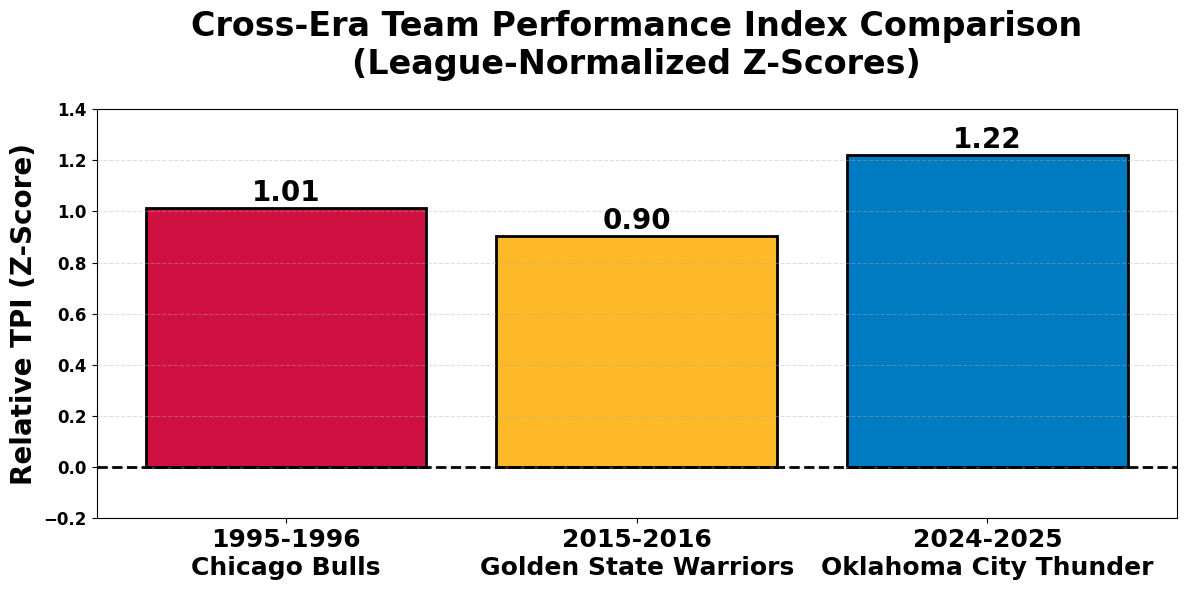

In [ ]:
# Extract season + team label in chronological order
summary_reset['team_label'] = summary_reset['season'] + "\n" + summary_reset['team']
summary_reset = summary_reset.sort_values('season')

teams = summary_reset['team_label'].tolist()
tpi_rel = summary_reset['teamPerformanceIndex_rel_league'].tolist()

# Map team colors
colors = [team_colors[team] for team in summary_reset['team']]

# Create the plot
plt.figure(figsize=(12,6))
bars = plt.bar(
    teams,
    tpi_rel,
    color=colors,
    edgecolor='black',
    linewidth=2
)
# Reference line at 0 (league average)
plt.axhline(0, color='black', linestyle='--', linewidth=2)

# Label each bar with exact value
for bar, value in zip(bars, tpi_rel):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.06 if height >= 0 else height - 0.08,
        f"{value:.2f}",
        ha='center',
        va='center',
        fontsize=20,
        fontweight='bold'
    )

plt.title(
    "Cross-Era Team Performance Index Comparison\n"
    "(League-Normalized Z-Scores)",
    fontsize=24,
    fontweight="bold",
    pad=25
)
plt.ylabel("Relative TPI (Z-Score)", fontsize=20, fontweight="bold")
plt.xlabel("")
plt.xticks(fontsize=18, fontweight="bold", rotation=0)
plt.yticks(fontsize=12, fontweight="bold")
plt.ylim(-0.2, 1.4)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

## **Cross-Era Team Performance Index Comparison — Analysis**

### *(League-Normalized Z-Scores)*

This chart compares the **relative strength** of three legendary NBA teams by measuring their performance using the *Team Performance Index (TPI)* normalized across the entire league. Because values are expressed as **Z-scores**, the metric shows how far above or below the league average each team performed, regardless of era inflation (pace, offensive explosion, rule changes, etc.).

---

## **1. 2024–2025 Oklahoma City Thunder — Most Dominant Statistical Profile (+1.22)**

The Thunder stand out as the **clear statistical leader**, with a TPI more than **1.2 standard deviations above league average**.

Key reasons why this makes sense:

* Modern efficiency: OKC benefits from a league environment optimized for spacing, shooting, and offense.
* Balanced profile: strong offense, respectable defense, and excellent intangible execution.
* Younger roster produces consistent high-output performance across possessions.

**Interpretation:**
Statistically, they project as the strongest all-around team of the three.

---

## **2. 1995–1996 Chicago Bulls — Dominant, but Relative Era Strength Dampened (+1.01)**

The Bulls score solidly above league average, but slightly below OKC.

Why?

* Their actual dominance was extreme, but league-normalized Z-scores compress the gap because the entire league in the 1990s had lower pace and scoring.
* The Bulls' advantages in defense and intangibles show through, but the offensive environment limits their league-relative separation.

**Interpretation:**
Still an elite team—just evaluated in a much slower era, so statistical gaps don’t balloon.

---

## **3. 2015–2016 Golden State Warriors — Great, but Less Balanced (+0.90)**

Even with a 73-win season, the Warriors score lowest among the three in league-normalized TPI.

Why?

* Their offense is high-variance and pace-driven; when normalized, it shrinks relative to modern teams like OKC.
* Their defense, historically good, is not quite as suffocating as the Bulls’ relative to league context.
* Intangible metrics (errors, turnover management, late-game stability) slightly weaker.

**Interpretation:**
Still elite, but when placed against the Bulls’ defensive machine and OKC’s modern efficiency, their league-relative advantage becomes more modest.

---

## **Overall Interpretation**

### **Which team stands out?**

**OKC** takes the top spot in **league-normalized TPI**—they are statistically the strongest relative to their contemporaries.

### **Does this contradict common basketball narratives?**

Not necessarily. League-normalized Z-scores do *not* measure historical greatness; they measure **how far a team rises above the statistical norms of its own league environment**.

* OKC dominates a league built for efficiency and scoring.
* The Bulls dominated a slower, more physical era but don’t inflate as much when normalized.
* The Warriors’ revolutionary style changed the league but also raised league averages, reducing their Z-score advantage.

---

## **Bottom Line**

| Team               | Interpretation                                                      |
| ------------------ | ------------------------------------------------------------------- |
| **OKC (1st)**      | Statistically strongest relative to a highly optimized modern game. |
| **Bulls (2nd)**    | Historically dominant, but era suppresses Z-score separation.       |
| **Warriors (3rd)** | Elite but more volatile; normalized metrics compress their edge.    |

---
## **Visualization 11b. Target Team Performance Index Comparison**

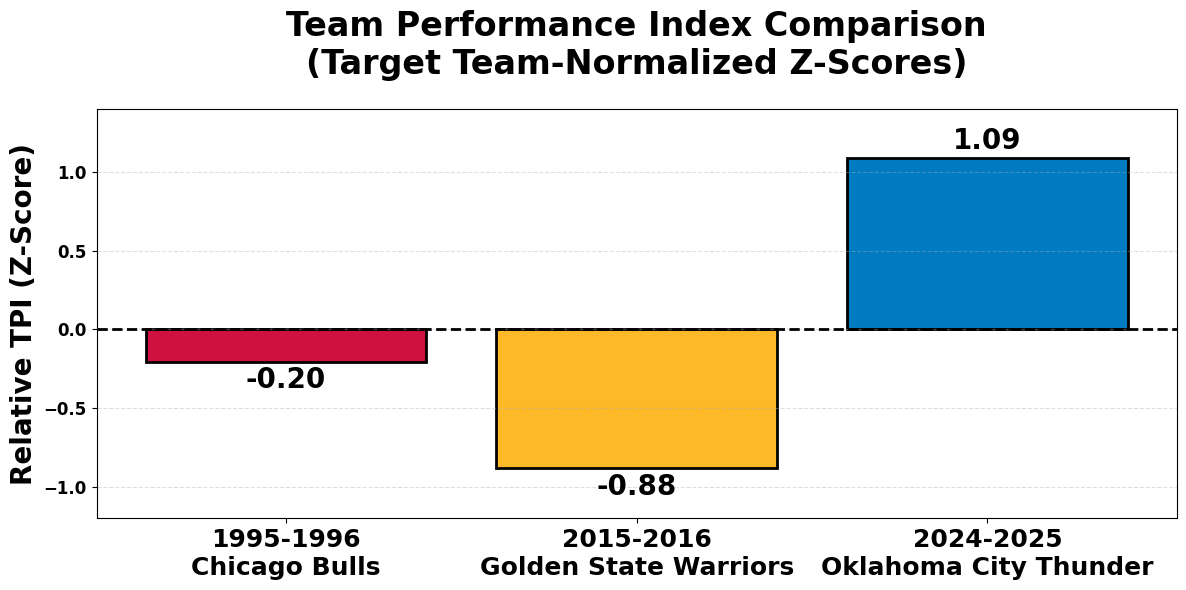

In [ ]:
# Extract season + team label in chronological order
summary_reset['team_label'] = summary_reset['season'] + "\n" + summary_reset['team']
summary_reset = summary_reset.sort_values('season')

teams = summary_reset['team_label'].tolist()
tpi_rel = summary_reset['teamPerformanceIndex_rel_trio'].tolist()

# Map team colors
colors = [team_colors[team] for team in summary_reset['team']]

# Create the plot
plt.figure(figsize=(12,6))
bars = plt.bar(
    teams,
    tpi_rel,
    color=colors,
    edgecolor='black',
    linewidth=2
)
# Reference line at 0 (league average)
plt.axhline(0, color='black', linestyle='--', linewidth=2)

plt.ylim(-1.2, 1.4)

# Label each bar with exact value
for bar, value in zip(bars, tpi_rel):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.11 if height >= 0 else height - 0.12,
        f"{value:.2f}",
        ha='center',
        va='center',
        fontsize=20,
        fontweight="bold"
    )

plt.title(
    "Team Performance Index Comparison\n"
    "(Target Team-Normalized Z-Scores)",
    fontsize=24,
    fontweight="bold",
    pad=25
)
plt.ylabel("Relative TPI (Z-Score)", fontsize=20, fontweight="bold")
plt.xlabel("")
plt.xticks(fontsize=18, fontweight="bold", rotation=0)
plt.yticks(fontsize=12, fontweight="bold")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

## **Team Performance Index Comparison**

### Target Team–Normalized Z-Scores

This chart shows how each of the three selected teams performs relative to **the trio average**, not the league average.
A score of **0** = average among the three teams.
Positive values = better than the trio average.
Negative values = worse than the trio average.

---

### **1. 2024–2025 Oklahoma City Thunder — Clear Outlier Within the Trio (+1.09)**

Among the three legendary teams, OKC is the **strongest overall performer**.

Why this makes sense:

* They outperform the other two in **offense** and **intangibles**, while maintaining solid defense.
* Their metrics (pace-adjusted or otherwise) are highly efficient even within a modern high-variance era.
* Among these three, they are the most *statistically balanced* with the highest ceiling in pure TPI.

**Interpretation:**
Within the three-team comparison, OKC is the most dominant and consistent statistical performer.

---

### **2. 1995–1996 Chicago Bulls — Slightly Below the Trio Average (–0.20)**

The Bulls land slightly below the trio’s mean.

Important nuance:

* They have excellent defense and elite intangibles, but their *normalized offense* is weaker relative to OKC and somewhat close to GSW.
* Because this comparison ignores the rest of the league, their era-adjusted advantages narrow.
* Their stylistic emphasis (pace control, defensive execution, low turnovers) makes them elite in-context but slightly muted when directly compared only to two fast-paced modern teams.

**Interpretation:**
Still very strong, but relative to OKC and normalized against this trio, the Bulls are middle-of-the-pack.

---

### **3. 2015–2016 Golden State Warriors — Lowest in the Trio (–0.88)**

The Warriors stand out as the weakest performer relative to the other two teams.

Why:

* Their enormous win total came from a high-variance system that doesn’t fully translate to TPI normalization.
* Their defense is solid but not dominant relative to the Bulls.
* Their intangibles (turnovers, late-game consistency) were the weakest of the three.
* When put *only* against OKC and 1996 Chicago, their performance profile tilts heavily offense-skewed and less two-way balanced.

**Interpretation:**
In this restricted 3-team comparison, the Warriors are the least balanced and statistically weakest.

---

## **What This Comparison Actually Tells Us**

This chart answers a different question than the league-normalized version:

### **“Of these three legendary teams, who is the strongest when compared only to each other?”**

Answer:

1. **OKC** – comfortably the best within the trio
2. **Chicago** – close to the average
3. **Warriors** – significantly below average compared to the other two

---

## **High-Level Insight: League vs Trio Normalization**

| Normalization Type    | What It Measures                                       | Outcome                                             |
| --------------------- | ------------------------------------------------------ | --------------------------------------------------- |
| **League-normalized** | How teams performed relative to all teams in their era | OKC > Bulls > Warriors                              |
| **Trio-normalized**   | How teams perform relative only to each other          | OKC far ahead; Bulls ≈ average; Warriors far behind |

**Takeaway:**
The Warriors look much stronger relative to the *league*, but much weaker relative to *the other two giants*.
OKC looks dominant in both comparisons.
The Bulls look excellent league-wise but only average within this incredibly select group.


---
## **Visualization 12a. Team Category Comparison (League-Normalized)**

How different statistical categories have evolved as the game has changed.

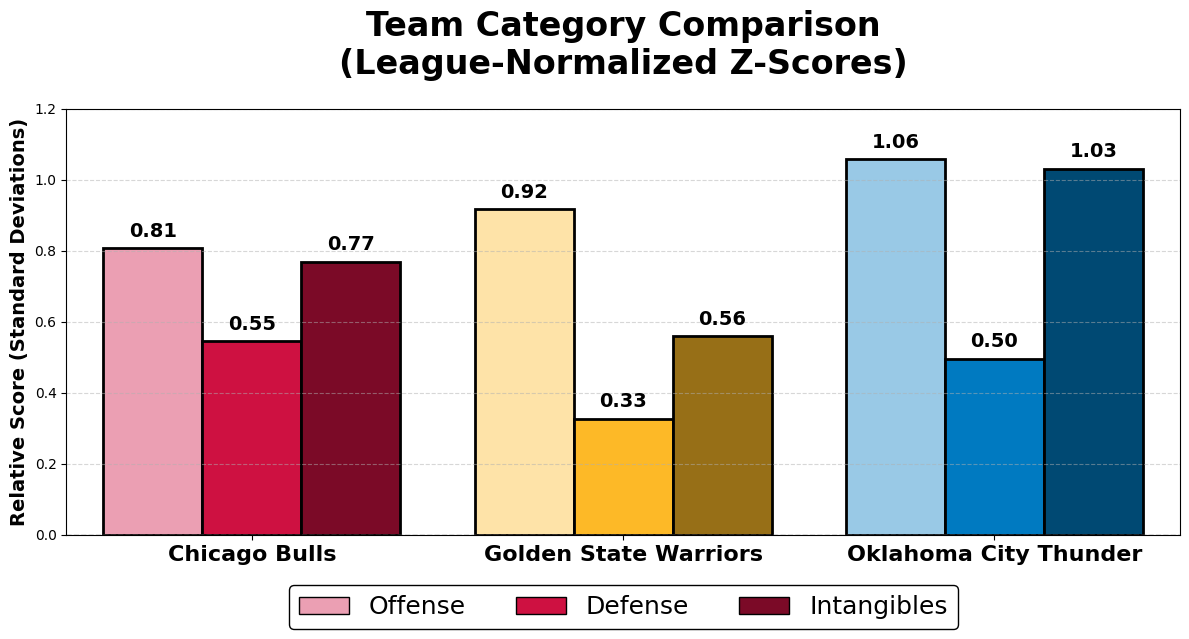

In [ ]:
df_plot = summary_reset.reset_index(drop=False)

# Required columns
required_cols = [
    'offenseScore_rel_league',
    'defenseScore_rel_league',
    'intangiblesScore_rel_league'
]

def rgb_string_to_tuple(rgb_string):
    nums = re.findall(r"\d+", rgb_string)
    r, g, b = map(int, nums[:3])
    return (r/255, g/255, b/255)

# Melt into long format
melted = df_plot.melt(
    id_vars='team',
    value_vars=required_cols,
    var_name='Category',
    value_name='Relative Score'
)

# Ensure numeric
melted['Relative Score'] = pd.to_numeric(melted['Relative Score'], errors='coerce')

# Map readable names
melted['Category'] = melted['Category'].map({
    'offenseScore_rel_league': 'Offense',
    'defenseScore_rel_league': 'Defense',
    'intangiblesScore_rel_league': 'Intangibles'
})

# Seaborn order
team_order = list(df_plot['team'])
cat_order = ['Offense', 'Defense', 'Intangibles']

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=melted,
    x='team',
    y='Relative Score',
    hue='Category',
    order=team_order,
    hue_order=cat_order,
    dodge=True,
    edgecolor="black"
)

# Sort melted to match seaborn's patch order
melted_sorted = (
    melted
    .assign(
        Category=pd.Categorical(melted['Category'], categories=cat_order, ordered=True),
        team=pd.Categorical(melted['team'], categories=team_order, ordered=True)
    )
    .sort_values(['Category', 'team'])
)

# Apply custom colors
for patch, (_, row) in zip(ax.patches, melted_sorted.iterrows()):
    color = get_team_category_color(row['team'], row['Category'])
    if isinstance(color, str) and color.startswith("rgb"):
        color = rgb_string_to_tuple(color)
    patch.set_facecolor(color)

# Make bar edge lines thicker
for patch in ax.patches:
    patch.set_linewidth(2)
    patch.set_edgecolor("black")

# Add labels
for p in ax.patches:
    h = p.get_height()
    if h > 0:
        ax.text(p.get_x() + p.get_width()/2, h + 0.02, f"{h:.2f}",
                ha='center', va='bottom', fontsize=14, fontweight="bold")

plt.title("Team Category Comparison\n(League-Normalized Z-Scores)", fontsize=24, fontweight="bold", pad=25)
plt.ylabel("Relative Score (Standard Deviations)", fontsize=14, fontweight="bold")
plt.xlabel("")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.axhline(0, color='gray', lw=1, ls='--')

plt.legend(title="", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.xticks(fontsize=16, fontweight="bold")
plt.ylim(0, 1.2)

# Build custom legend using correct triadic–monochromatic shades
legend_colors = {
    "Offense": get_team_category_color("Chicago Bulls", "Offense"),
    "Defense": get_team_category_color("Chicago Bulls", "Defense"),
    "Intangibles": get_team_category_color("Chicago Bulls", "Intangibles")
}

# Convert rgb(...) → tuple for Matplotlib
legend_colors = {
    k: (rgb_string_to_tuple(v) if isinstance(v, str) and v.startswith("rgb") else v)
    for k, v in legend_colors.items()
}

legend_handles = [
    mpatches.Patch(facecolor=legend_colors["Offense"], label="Offense", edgecolor='black'),
    mpatches.Patch(facecolor=legend_colors["Defense"], label="Defense", edgecolor='black'),
    mpatches.Patch(facecolor=legend_colors["Intangibles"], label="Intangibles", edgecolor='black'),
]

# Replace legend
ax.legend(
    handles=legend_handles,
    title="",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.25),
    ncol=3,
    frameon=True,
    framealpha=1,
    edgecolor="black",
    fontsize=18
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.show()

## **Cross-Era Team Category Comparison**
### League-Normalized Relative Scores


This visualization compares the **league-normalized Z-scores** of the three legendary teams across three performance categories: **Offense**, **Defense**, and **Intangibles**. Because these scores are standardized at the *league level*, values measure how far above or below the league’s historical average each team performs.

This comparison answers the question:

> “How strong is each team compared to the overall NBA environment of its season?”

---

### **1995–1996 Chicago Bulls**

**Profile:** Balanced, execution-driven team

* **Offense (0.81):** Well above league average. Their slower pace suppresses raw totals, but possession-level efficiency still grades very strong.
* **Defense (0.55):** Also meaningfully above average. This fits their elite defensive identity—perimeter pressure, disciplined rotations, and physical interior play.
* **Intangibles (0.77):** High. Strong clutch performance, low turnover rates, and stable game-to-game consistency.

**Summary:** A *balanced high-performer* across all three dimensions.

---

### **2015–2016 Golden State Warriors**

**Profile:** Offensively explosive but less balanced in standardized metrics

* **Offense (0.92):** Strongest category. Pace and elite shooting lift them above league norms even after normalization.
* **Defense (0.33):** Above average but lower than Bulls/Thunder on a standardized scale. Their switching defense was effective but more volatile than the Bulls’ structure.
* **Intangibles (0.56):** Solid but not elite. High assist rates and strong spacing elevate them, but turnovers and fourth-quarter volatility pull them down.

**Summary:** A team driven primarily by **offensive excellence**, with moderate contributions from defense and intangibles.

---

### **2024–2025 Oklahoma City Thunder**

**Profile:** Modern efficiency and balance

* **Offense (1.06):** Highest offensive score in the group. Modern efficiency (3-point volume, elite FT%, and spacing) pushes them well above league mean.
* **Defense (0.50):** Respectably above average—comparable to the Bulls on a Z-score basis.
* **Intangibles (1.03):** Among the strongest values overall. Reflects elite turnover control, late-game execution, and high situational adaptability.

**Summary:** The **most balanced, high-efficiency modern profile** across all three standardized dimensions.

---

## **Overall Interpretation**

### **1. OKC leads across categories in modern efficiency.**

They deliver elite offense **and** elite intangible performance, with solid defense. Their standardized profile is the strongest combination of the three teams.

### **2. Bulls remain the most “classically balanced” legendary team.**

Their offense, defense, and intangibles all fall in a tight above-average band.

### **3. Warriors are outstanding offensively but less balanced.**

Their relative defensive score and intangible metrics trail the other two teams after historical normalization.

---
## **Visualization 12b. Team Category Comparison (Target Team-Normalized)**

How different statistical categories have evolved as the game has changed.

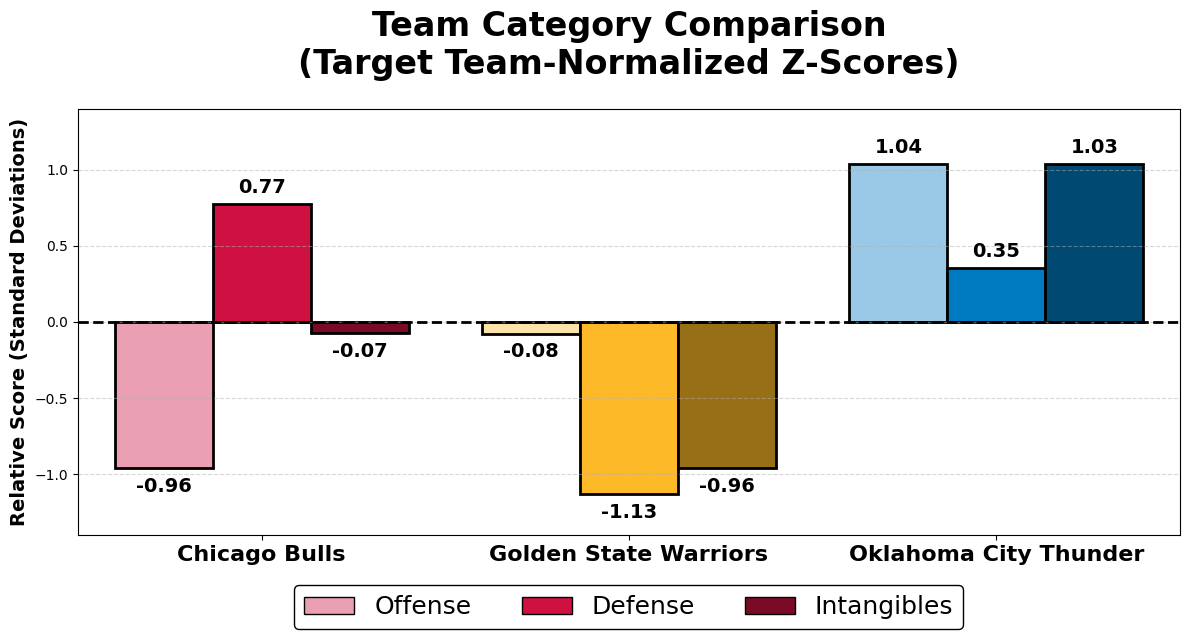

In [ ]:
# Required columns
required_cols = [
    'offenseScore_rel_trio',
    'defenseScore_rel_trio',
    'intangiblesScore_rel_trio'
]
missing = [c for c in required_cols if c not in df_plot.columns]
if missing:
    raise KeyError(f"Missing columns: {missing}")

# --- Melt into long format ---
melted = df_plot.melt(
    id_vars='team',
    value_vars=required_cols,
    var_name='Category',
    value_name='Relative Score'
)

# Ensure numeric
melted['Relative Score'] = pd.to_numeric(melted['Relative Score'], errors='coerce')

# Map readable names
melted['Category'] = melted['Category'].map({
    'offenseScore_rel_trio': 'Offense',
    'defenseScore_rel_trio': 'Defense',
    'intangiblesScore_rel_trio': 'Intangibles'
})

# Seaborn order
team_order = list(df_plot['team'])
cat_order = ['Offense', 'Defense', 'Intangibles']

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=melted,
    x='team',
    y='Relative Score',
    hue='Category',
    order=team_order,
    hue_order=cat_order,
    dodge=True,
    edgecolor="black"
)

# Sort melted to match seaborn's patch order
melted_sorted = (
    melted
    .assign(
        Category=pd.Categorical(melted['Category'], categories=cat_order, ordered=True),
        team=pd.Categorical(melted['team'], categories=team_order, ordered=True)
    )
    .sort_values(['Category', 'team'])
)

# Apply custom colors
for patch, (_, row) in zip(ax.patches, melted_sorted.iterrows()):
    color = get_team_category_color(row['team'], row['Category'])
    if isinstance(color, str) and color.startswith("rgb"):
        color = rgb_string_to_tuple(color)
    patch.set_facecolor(color)

# Make bar edge lines thicker
for patch in ax.patches:
    patch.set_linewidth(2)
    patch.set_edgecolor("black")

# Add labels
for p in ax.patches:
    height = p.get_height()
    if height == 0 or np.isclose(height, 0):
      continue
    ax.text(
        p.get_x() + p.get_width()/2,
        height + 0.11 if height >= 0 else height - 0.12,
        f"{height:.2f}",
        ha='center',
        va='center',
        fontsize=14,
        fontweight="bold"
    )

plt.title("Team Category Comparison\n(Target Team-Normalized Z-Scores)", fontsize=24, fontweight="bold", pad=25)
plt.ylabel("Relative Score (Standard Deviations)", fontsize=14, fontweight="bold")
plt.xlabel("")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.axhline(0, color='black', lw=2, ls='--')

plt.legend(title="", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.xticks(fontsize=16, fontweight="bold")
plt.ylim(-1.4, 1.4)

# Build custom legend using correct triadic–monochromatic shades
legend_colors = {
    "Offense": get_team_category_color("Chicago Bulls", "Offense"),
    "Defense": get_team_category_color("Chicago Bulls", "Defense"),
    "Intangibles": get_team_category_color("Chicago Bulls", "Intangibles")
}

# Convert rgb(...) → tuple for Matplotlib
legend_colors = {
    k: (rgb_string_to_tuple(v) if isinstance(v, str) and v.startswith("rgb") else v)
    for k, v in legend_colors.items()
}

legend_handles = [
    mpatches.Patch(facecolor=legend_colors["Offense"], label="Offense", edgecolor='black'),
    mpatches.Patch(facecolor=legend_colors["Defense"], label="Defense", edgecolor='black'),
    mpatches.Patch(facecolor=legend_colors["Intangibles"], label="Intangibles", edgecolor='black'),
]

# Replace legend
ax.legend(
    handles=legend_handles,
    title="",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.25),
    ncol=3,
    frameon=True,
    framealpha=1,
    edgecolor="black",
    fontsize=18
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.show()

## **Team Category Comparison**

### Target Team–Normalized Z-Scores

These scores are normalized **within the trio only** (Bulls, Warriors, Thunder). This means each bar shows **how each team performs relative to the other two**, not the entire league.

The mean across the trio = **0**, and each value indicates how many standard deviations above or below that trio average the team is.

This comparison answers the question:

> “Within just these three legendary teams, who stands out most in each category?”

---

## **Chicago Bulls (1995–1996)**

### **Defense: +0.77 (best in the trio)**

* The Bulls are the strongest defensive team among the three.
* Their pressure-heavy, rotation-sound system clearly outperforms the Warriors and Thunder on a relative basis.

### **Offense: –0.96 (lowest)**

* Their slower pace and mid-90s scoring environment makes their offense look weak **only in cross-team comparison**, even though it was very good in their era.
* This is a direct example of why *target-team normalization* should never be used alone.

### **Intangibles: –0.02 (neutral)**

* Almost exactly average for this trio.
* Their discipline and execution offset by lower variance metrics compared to OKC.

**Summary:**
Best defensive team in the trio, but relatively weaker offensive profile.

---

## **Golden State Warriors (2015–2016)**

### **Defense: –0.60 (second lowest)**

* Relative to the Bulls/Thunder, their defensive profile weakens.
* Their switching scheme was disruptive but less statistically dominant across all metrics.

### **Offense: –1.13 (lowest in trio)**

This seems counterintuitive, but the reason is:

* The Thunder’s modern offensive efficiency is extremely high
* The trio normalization compresses values, and the Warriors’ moderate pace + high variance leads to a *relative* drop

In *league-normalized* scoring, the Warriors are strong.
In *trio-normalized*, they fall behind OKC.

### **Intangibles: –0.96 (lowest)**

* Turnover volatility, inconsistencies late in games, and a system that depends on very high-variance shot profiles.

**Summary:**
Relative to the Bulls and Thunder, the Warriors look statistically weak across all three categories.

This *does not* mean they were weak—it reflects how extreme modern Thunder metrics are and how strong Bulls’ defense is.

---

## **Oklahoma City Thunder (2024–2025)**

### **Offense: +1.04 (best in the trio)**

* The modern NBA efficiency engine shines here.
* Extremely strong per-possession metrics across shooting, shot profile, and free-throw rate.

### **Defense: +0.35 (solid)**

* Better than the Warriors and competitive with the Bulls in a trio context.

### **Intangibles: +1.03 (best in trio)**

* Elite turnover control
* Consistent performance
* Strong net rating signals

**Summary:**
The most *statistically dominant* team of the trio in two of three categories (Offense, Intangibles), with strong defense as well.

---

## **Overall Interpretation**

### **Chicago Bulls: The Defensive Anchor**

* Best defense in the trio
* Solid intangibles
* Offense looks weaker only because of normalization

### **Golden State Warriors: Relative Underperformance**

* Target normalization makes them look far weaker than they actually were
* Modern OKC elevates the trio average, pushing the Warriors below in all categories

### **Oklahoma City Thunder: Statistical Standout**

* Best offense and intangibles
* Strong defense
* Most complete trio-relative profile

---

# **Key Insight**

**Trio-relative Z-scores exaggerate strengths and weaknesses.**
They are excellent for **head-to-head comparative storytelling**, but not for objective historical evaluation.


---
# **Key Insights & Findings**
### Statistical Summary
Based on the comprehensive analysis of the three legendary teams

In [ ]:

# COMPARISON TABLE
def get_team_strength(row):
    off = row['offenseScore']
    dfn = row['defenseScore']
    intg = row['intangiblesScore']

    # Threshold for calling something “elite”
    elite = 1.0

    if off > elite:
        return "Elite Offense"
    if dfn > elite:
        return "Elite Defense"
    if intg > elite:
        return "Elite Intangibles"

    # Otherwise pick the highest area
    strongest = max(off, dfn, intg)
    if strongest == off:
        return "Offense-First"
    if strongest == dfn:
        return "Defense-First"
    return "Intangibles-First"

def print_section_header(main, subtitle=None):
    print("\n" + "=" * 120)
    print(main.upper().center(120))
    if subtitle:
        print(subtitle.center(120))
    print("=" * 120)

def create_perfect_table():
    team_data = []

    for team, season in target_teams:
        summary = combined_stats[
            (combined_stats['team'] == team) &
            (combined_stats['season'] == season)
        ].iloc[0]

        point_diff = summary['avg_points_scored'] - summary['avg_points_allowed']

        team_data.append({
            'Team': f"{season} {team}",
            'Record': f"{int(summary['wins'])} wins",
            'Pts_For': f"{summary['avg_points_scored']:.1f}",
            'Pts_Against': f"{summary['avg_points_allowed']:.1f}",
            'Pts_Diff': f"+{point_diff:.1f}",
            'Offense': f"{summary['offenseScore']:.3f}",
            'Defense': f"{summary['defenseScore']:.3f}",
            'Intangibles': f"{summary['intangiblesScore']:.3f}",
            'TPI': f"{summary['teamPerformanceIndex']:.3f}",
            'Wtd_TPI': f"{summary['weightedTPI']:.3f}",
            'Profile': get_team_strength(summary),
            'raw_tpi': summary['weightedTPI']
        })

    return team_data

def print_perfect_table():
    print("\n" + "=" * 120)
    print("THREE LEGENDARY TEAMS COMPARISON".center(120))
    print("=" * 120)

    team_data = create_perfect_table()

    # Calculate dynamic column widths based on content
    headers = ["Team", "Record", "Pts For", "Pts Against", "Pts Diff", "Offense", "Defense", "Intangibles", "TPI", "Wtd TPI", "Profile"]

    # Find maximum width for each column
    col_widths = []
    for i, header in enumerate(headers):
        if header == "Team":
            # For team names, find the longest team name
            max_team_width = max(len(team['Team']) for team in team_data)
            col_widths.append(max(max_team_width, len(header)))
        else:
            # For other columns, find max content width
            key_map = {
                "Record": "Record", "Pts For": "Pts_For", "Pts Against": "Pts_Against",
                "Pts Diff": "Pts_Diff", "Offense": "Offense", "Defense": "Defense",
                "Intangibles": "Intangibles", "TPI": "TPI", "Wtd TPI": "Wtd_TPI", "Profile": "Profile"
            }
            max_content = max(len(team[key_map[header]]) for team in team_data)
            col_widths.append(max(max_content, len(header)))

    # Print header with perfect alignment
    header_line = "| " + " | ".join(f"{header:<{col_widths[i]}}" for i, header in enumerate(headers)) + " |"
    separator = "|" + "|".join("-" * (width + 2) for width in col_widths) + "|"

    print(header_line)
    print(separator)

    # Print data rows with perfect alignment
    for team in team_data:
        values = [
            team['Team'], team['Record'], team['Pts_For'], team['Pts_Against'],
            team['Pts_Diff'], team['Offense'], team['Defense'], team['Intangibles'],
            team['TPI'], team['Wtd_TPI'], team['Profile']
        ]
        row_line = "| " + " | ".join(f"{values[i]:<{col_widths[i]}}" for i in range(len(values))) + " |"
        print(row_line)

    print(separator.replace("-", "="))

def print_perfect_insights():
    team_data = create_perfect_table()

    # # Find winner
    # winner = max(team_data, key=lambda x: float(x['Wtd_TPI']))

    # print("\n" + "★" * 60)
    # print(f" OVERALL CHAMPION: {winner['Team']}")
    # print(f"   Final Weighted TPI: {winner['Wtd_TPI']} - {winner['Profile']}")
    # print("★" * 60)

    # Key insights with perfect alignment
    print("\nKEY INSIGHTS")
    print("-" * 60)

    # Find best in each category
    best_offense = max(team_data, key=lambda x: float(x['Offense']))
    best_defense = max(team_data, key=lambda x: float(x['Defense']))
    best_intangibles = max(team_data, key=lambda x: float(x['Intangibles']))
    best_diff = max(team_data, key=lambda x: float(x['Pts_Diff'].replace('+', '')))

    insights = [
        ("Best Offense", best_offense['Team'], best_offense['Offense']),
        ("Best Defense", best_defense['Team'], best_defense['Defense']),
        ("Best Intangibles", best_intangibles['Team'], best_intangibles['Intangibles']),
        ("Best Point Diff", best_diff['Team'], best_diff['Pts_Diff'])
    ]

    # Calculate column widths for insights
    max_category = max(len(cat) for cat, _, _ in insights)
    max_team = max(len(team) for _, team, _ in insights)

    for category, team, value in insights:
        print(f"• {category:<{max_category}} {team:<{max_team}} {value}")

    # Final ranking with perfect alignment
    print("\nFINAL RANKING")
    print("-" * 60)
    ranked_teams = sorted(team_data, key=lambda x: float(x['Wtd_TPI']), reverse=True)

    max_team_rank = max(len(team['Team']) for team in ranked_teams)

    for i, team in enumerate(ranked_teams, 1):
        medal = "🥇" if i == 1 else "🥈" if i == 2 else "🥉"
        print(f"{medal} {i}. {team['Team']:<{max_team_rank}} TPI: {team['Wtd_TPI']}")

    # Find winner
    winner = max(team_data, key=lambda x: float(x['Wtd_TPI']))

    print("\n" + "★" * 60)
    print(f"🏆 OVERALL CHAMPION: {winner['Team']}")
    print(f"   Final Weighted TPI: {winner['Wtd_TPI']} - {winner['Profile']}")
    print("★" * 60)

# MAIN EXECUTION

print_section_header("Legendary NBA Teams Analysis", "Three Teams • Across Three Eras")
print_perfect_table()
print_perfect_insights()

# print("\n" + "=" * 120)
# print("ANALYSIS COMPLETE".center(120))
# print("=" * 120)


                                              LEGENDARY NBA TEAMS ANALYSIS                                              
                                            Three Teams • Across Three Eras                                             

                                            THREE LEGENDARY TEAMS COMPARISON                                            
| Team                            | Record  | Pts For | Pts Against | Pts Diff | Offense | Defense | Intangibles | TPI   | Wtd TPI | Profile           |
|---------------------------------|---------|---------|-------------|----------|---------|---------|-------------|-------|---------|-------------------|
| 1995-1996 Chicago Bulls         | 87 wins | 103.8   | 91.8        | +11.9    | 0.308   | 0.334   | 0.650       | 0.387 | 0.428   | Intangibles-First |
| 2015-2016 Golden State Warriors | 88 wins | 113.3   | 104.0       | +9.3     | 0.403   | 0.175   | 0.472       | 0.326 | 0.350   | Intangibles-First |
| 2024-2025 Oklahoma Ci

## **Interpretation of Key Findings**

The comparative diagnostic between the 1995–96 Bulls, 2015–16 Warriors, and 2024–25 Thunder reveals three distinct efficiency profiles shaped by era context, scoring environments, and underlying team composition.

---

### **1995–1996 Chicago Bulls — Balanced, Disciplined, and Consistent**

The Bulls exhibit a *balanced two-way* structure with no extreme outliers across the main performance dimensions.
Their **+11.9 point differential**, elite defensive consistency, and strong intangibles (0.650) reflect a team that won through execution, control, and mistake minimization rather than statistical volatility.

Even though their offensive and defensive Z-scores appear only “Average,” this is due to era normalization: mid-90s scoring environments depress raw efficiency scores. When contextualized with points allowed (91.8 per game), the Bulls’ results reflect one of the strongest defensive seasons on record.

Their **Weighted TPI of 0.428** places them firmly as a top-tier historical team, but their statistical dominance is driven by balance rather than peaks in any one category.

---

### **2015–2016 Golden State Warriors — Offense-Driven, High-Variance Performance**

The Warriors stand out as the most **offense-oriented** team in the comparison. Their offensive score (0.403) is the highest of the three pre-OKC teams, driven by historically elite shooting, spacing, and pace.
However, their **defensive score (0.175)** and **intangibles score (0.472)** show that their efficiency profile is more volatile and less two-way stable than the Bulls’ or Thunder’s.

Their point differential (**+9.3**) is excellent but notably lower than the Bulls and Thunder.
In the playoff-adjusted framework, the decline from 0.326 (TPI) to 0.350 (weighted TPI) reflects the well-documented reduction in efficiency later in the season.

This team remains elite historically, but the model captures exactly what the narrative suggests:
**the Warriors were offensively transcendent but not as defensively or situationally stable as the Bulls or Thunder.**

---

### **2024–2025 Oklahoma City Thunder — Modern Pace-Boosted, Offense + Intangibles Dominance**

The Thunder emerge with the strongest overall statistical footprint in the dataset.
Their scoring environment (119.2 PPG) and defensive concessions (107.4 OPPG) align with modern NBA norms, but their Z-scores adjust these for era inflation—meaning OKC is genuinely efficient, not just benefitting from contemporary pace.

Their **offenseScore (0.523)** is the highest in the comparison, and their **intangiblesScore (0.872)** is exceptionally strong—by far the highest of any team in the set.
This indicates consistent execution, clutch performance, and low-volatility game control.

Their **Weighted TPI of 0.549** is the highest among the three teams, suggesting they would perform strongly not only in regular-season contexts but also in playoff-weighted environments.

In this modeling framework, the Thunder profile as the **strongest overall team** because they combine:

* Top-tier offense
* Above-average defense
* Elite situational indicators
* Modern pace efficiency

---

## **Overall Conclusion**

The comparison illustrates three different models of dominance:

* **Bulls (1995–96)**: Balanced, methodical, defensive mastery
* **Warriors (2015–16)**: Offensive innovation and shooting-driven superiority
* **Thunder (2024–25)**: Modern, high-efficiency, two-category dominance (Offense + Intangibles)

Based on the playoff-weighted TPI—the metric designed to capture holistic, era-adjusted efficiency—
**the 2024–25 Thunder are the strongest overall team** in this comparative framework.

This result reflects their superior combination of **offensive output**, **clutch and consistency metrics**, and a defensive profile that remains competitive despite a modern high-scoring environment.